# Univariate LSTM model for volatility forecasting

# 1. Importing packages 

In [96]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import t
import collections
from tabulate import tabulate
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from scipy.stats import norm
from arch.unitroot import ZivotAndrews
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import CHTest
from matplotlib.ticker import MaxNLocator


In [97]:
import ruptures as rpt
import statsmodels.api as sm
from tqdm.notebook import tqdm

## 1.1 Importing functions  

In [98]:
from Model_functions import scaled_data, make_supervised, test_batch, lstm_model, generate_2_forecasts, generate_2_forecasts_hybrid, generate_forecasts_hybrid_no_rf
from Model_functions import calc_errors, calc_errors_ms, univariate_lstm_preds, dm_test_2, calc_errors_lstm, rv_calc
from Model_functions import make_supervised_shift, univariate_lstm_preds_shift, generate_2_forecasts_hybrid_shift, create_h_step_forecasts

# 2. Data exploration 

In [99]:
log_returns = pd.read_csv('1. Electricity price datasets/log_returns_spain.csv')
prices = pd.read_csv('1. Electricity price datasets/european_wholesale_electricity_price_data_hourly.csv')

In [100]:
# Features
matrix_feature_1 = pd.read_csv('2. GARCH Modelling/1_EP/EP_features/EP_feature_matrix_1.csv')
matrix_feature_12 = pd.read_csv('2. GARCH Modelling/1_EP/EP_features/EP_feature_matrix_12.csv')
matrix_feature_24 = pd.read_csv('2. GARCH Modelling/1_EP/EP_features/EP_feature_matrix_24.csv')

# Predictions
matrix_predictions_1 = pd.read_csv('2. GARCH Modelling/1_EP/EP_predictions/EP_prediction_matrix_1.csv')
matrix_predictions_12 = pd.read_csv('2. GARCH Modelling/1_EP/EP_predictions/EP_prediction_matrix_12.csv')
matrix_predictions_24 = pd.read_csv('2. GARCH Modelling/1_EP/EP_predictions/EP_prediction_matrix_24.csv')

## 2.1 Unpacking predictions & features of the electricity price data of the GARCH-type models 

### 2.1.1 1-step ahead predictions

In [18]:
# Unpacking the prediction matrix
preds_arch_norm_1 = matrix_predictions_1['ARCH-Norm']
preds_arch_std_1 = matrix_predictions_1['ARCH-Std']
preds_arch_ged_1 = matrix_predictions_1['ARCH-GED']
preds_garch_norm_1 = matrix_predictions_1['GARCH-Norm']
preds_garch_std_1 = matrix_predictions_1['GARCH-Std']
preds_garch_ged_1 = matrix_predictions_1['GARCH-GED']
preds_e_garch_norm_1 = matrix_predictions_1['E-GARCH-Norm']
preds_e_garch_std_1 = matrix_predictions_1['E-GARCH-Std']
preds_e_garch_ged_1 = matrix_predictions_1['E-GARCH-GED']
preds_gjr_garch_norm_1 = matrix_predictions_1['GJR-GARCH-Norm']
preds_gjr_garch_std_1 = matrix_predictions_1['GJR-GARCH-Std']
preds_gjr_garch_ged_1 = matrix_predictions_1['GJR-GARCH-GED']
preds_ms_garch_norm_1 = matrix_predictions_1['MS-GARCH-Norm']
preds_ms_garch_std_1 = matrix_predictions_1['MS-GARCH-Std']
preds_ms_garch_ged_1 = matrix_predictions_1['MS-GARCH-GED']

### 2.1.2 12-step ahead prediction matrix

In [19]:
# Unpacking the prediction matrix
preds_arch_norm_12 = matrix_predictions_12['ARCH-Norm']
preds_arch_std_12 = matrix_predictions_12['ARCH-Std']
preds_arch_ged_12 = matrix_predictions_12['ARCH-GED']
preds_garch_norm_12 = matrix_predictions_12['GARCH-Norm']
preds_garch_std_12 = matrix_predictions_12['GARCH-Std']
preds_garch_ged_12 = matrix_predictions_12['GARCH-GED']
preds_e_garch_norm_12 = matrix_predictions_12['E-GARCH-Norm']
preds_e_garch_std_12 = matrix_predictions_12['E-GARCH-Std']
preds_e_garch_ged_12 = matrix_predictions_12['E-GARCH-GED']
preds_gjr_garch_norm_12 = matrix_predictions_12['GJR-GARCH-Norm']
preds_gjr_garch_std_12 = matrix_predictions_12['GJR-GARCH-Std']
preds_gjr_garch_ged_12 = matrix_predictions_12['GJR-GARCH-GED']
preds_ms_garch_norm_12 = matrix_predictions_12['MS-GARCH-Norm']
preds_ms_garch_std_12 = matrix_predictions_12['MS-GARCH-Std']
preds_ms_garch_ged_12 = matrix_predictions_12['MS-GARCH-GED']

### 2.1.3 24-step ahead prediction matrix

In [20]:
# Unpacking the prediction matrix
preds_arch_norm_24 = matrix_predictions_24['ARCH-Norm']
preds_arch_std_24 = matrix_predictions_24['ARCH-Std']
preds_arch_ged_24 = matrix_predictions_24['ARCH-GED']
preds_garch_norm_24 = matrix_predictions_24['GARCH-Norm']
preds_garch_std_24 = matrix_predictions_24['GARCH-Std']
preds_garch_ged_24 = matrix_predictions_24['GARCH-GED']
preds_e_garch_norm_24 = matrix_predictions_24['E-GARCH-Norm']
preds_e_garch_std_24 = matrix_predictions_24['E-GARCH-Std']
preds_e_garch_ged_24 = matrix_predictions_24['E-GARCH-GED']
preds_gjr_garch_norm_24 = matrix_predictions_24['GJR-GARCH-Norm']
preds_gjr_garch_std_24 = matrix_predictions_24['GJR-GARCH-Std']
preds_gjr_garch_ged_24 = matrix_predictions_24['GJR-GARCH-GED']
preds_ms_garch_norm_24 = matrix_predictions_24['MS-GARCH-Norm']
preds_ms_garch_std_24 = matrix_predictions_24['MS-GARCH-Std']
preds_ms_garch_ged_24 = matrix_predictions_24['MS-GARCH-GED']

### 2.1.4 1-step ahead features matrix

In [101]:
# Unpacking the prediction matrix
feat_arch_norm_1 = matrix_feature_1['ARCH-Norm']
feat_arch_std_1 = matrix_feature_1['ARCH-Std']
feat_arch_ged_1 = matrix_feature_1['ARCH-GED']
feat_garch_norm_1 = matrix_feature_1['GARCH-Norm']
feat_garch_std_1 = matrix_feature_1['GARCH-Std']
feat_garch_ged_1 = matrix_feature_1['GARCH-GED']
feat_e_garch_norm_1 = matrix_feature_1['E-GARCH-Norm']
feat_e_garch_std_1 = matrix_feature_1['E-GARCH-Std']
feat_e_garch_ged_1 = matrix_feature_1['E-GARCH-GED']
feat_gjr_garch_norm_1 = matrix_feature_1['GJR-GARCH-Norm']
feat_gjr_garch_std_1 = matrix_feature_1['GJR-GARCH-Std']
feat_gjr_garch_ged_1 = matrix_feature_1['GJR-GARCH-GED']
feat_ms_garch_norm_1 = matrix_feature_1['MS-GARCH-Norm']
feat_ms_garch_std_1 = matrix_feature_1['MS-GARCH-Std']
feat_ms_garch_ged_1 = matrix_feature_1['MS-GARCH-GED']

### 2.1.4 12-step ahead features matrix

In [102]:
# Unpacking the prediction matrix
feat_arch_norm_12 = matrix_feature_12['ARCH-Norm']
feat_arch_std_12 = matrix_feature_12['ARCH-Std']
feat_arch_ged_12 = matrix_feature_12['ARCH-GED']
feat_garch_norm_12 = matrix_feature_12['GARCH-Norm']
feat_garch_std_12 = matrix_feature_12['GARCH-Std']
feat_garch_ged_12 = matrix_feature_12['GARCH-GED']
feat_e_garch_norm_12 = matrix_feature_12['E-GARCH-Norm']
feat_e_garch_std_12 = matrix_feature_12['E-GARCH-Std']
feat_e_garch_ged_12 = matrix_feature_12['E-GARCH-GED']
feat_gjr_garch_norm_12 = matrix_feature_12['GJR-GARCH-Norm']
feat_gjr_garch_std_12 = matrix_feature_12['GJR-GARCH-Std']
feat_gjr_garch_ged_12 = matrix_feature_12['GJR-GARCH-GED']
feat_ms_garch_norm_12 = matrix_feature_12['MS-GARCH-Norm']
feat_ms_garch_std_12 = matrix_feature_12['MS-GARCH-Std']
feat_ms_garch_ged_12 = matrix_feature_12['MS-GARCH-GED']

### 2.1.6 24-step ahead features matrix

In [103]:
# Unpacking the prediction matrix
feat_arch_norm_24 = matrix_feature_24['ARCH-Norm']
feat_arch_std_24 = matrix_feature_24['ARCH-Std']
feat_arch_ged_24 = matrix_feature_24['ARCH-GED']
feat_garch_norm_24 = matrix_feature_24['GARCH-Norm']
feat_garch_std_24 = matrix_feature_24['GARCH-Std']
feat_garch_ged_24 = matrix_feature_24['GARCH-GED']
feat_e_garch_norm_24 = matrix_feature_24['E-GARCH-Norm']
feat_e_garch_std_24 = matrix_feature_24['E-GARCH-Std']
feat_e_garch_ged_24 = matrix_feature_24['E-GARCH-GED']
feat_gjr_garch_norm_24 = matrix_feature_24['GJR-GARCH-Norm']
feat_gjr_garch_std_24 = matrix_feature_24['GJR-GARCH-Std']
feat_gjr_garch_ged_24 = matrix_feature_24['GJR-GARCH-GED']
feat_ms_garch_norm_24 = matrix_feature_24['MS-GARCH-Norm']
feat_ms_garch_std_24 = matrix_feature_24['MS-GARCH-Std']
feat_ms_garch_ged_24 = matrix_feature_24['MS-GARCH-GED']

## Load LSTM preds

In [143]:
lstm_preds_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_1.csv')
lstm_preds_arch_norm_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_arch_norm_1.csv')
lstm_preds_arch_std_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_arch_std_1.csv') 
lstm_preds_arch_ged_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_arch_ged_1.csv') 
lstm_preds_garch_norm_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_garch_norm_1.csv') 
lstm_preds_garch_std_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_garch_std_1.csv') 
lstm_preds_garch_ged_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_garch_ged_1.csv') 
lstm_preds_egarch_norm_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_egarch_norm_1.csv') 
lstm_preds_egarch_std_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_egarch_std_1.csv') 
lstm_preds_egarch_ged_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_egarch_ged_1.csv')
lstm_preds_gjrgarch_norm_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_gjrgarch_norm_1.csv')
lstm_preds_gjrgarch_std_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_gjrgarch_std_1.csv') 
lstm_preds_gjrgarch_ged_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_gjrgarch_ged_1.csv')
lstm_preds_msgarch_norm_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_msgarch_norm_1.csv')
lstm_preds_msgarch_std_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_msgarch_std_1.csv') 
lstm_preds_msgarch_ged_1 = pd.read_csv('6. LSTM predictions/Spain/lstm_preds_msgarch_ged_1.csv')

In [7]:
lstm_preds_12 = pd.read_csv('6. LSTM predictions/lstm_preds_12.csv')
lstm_preds_arch_norm_12 = pd.read_csv('6. LSTM predictions/lstm_preds_arch_norm_12.csv')
lstm_preds_arch_std_12 = pd.read_csv('6. LSTM predictions/lstm_preds_arch_std_12.csv') 
lstm_preds_arch_ged_12 = pd.read_csv('6. LSTM predictions/lstm_preds_arch_ged_12.csv') 
lstm_preds_garch_norm_12 = pd.read_csv('6. LSTM predictions/lstm_preds_garch_norm_12.csv') 
lstm_preds_garch_std_12 = pd.read_csv('6. LSTM predictions/lstm_preds_garch_std_12.csv') 
lstm_preds_garch_ged_12 = pd.read_csv('6. LSTM predictions/lstm_preds_garch_ged_12.csv') 
lstm_preds_egarch_norm_12 = pd.read_csv('6. LSTM predictions/lstm_preds_egarch_norm_12.csv') 
lstm_preds_egarch_std_12 = pd.read_csv('6. LSTM predictions/lstm_preds_egarch_std_12.csv') 
lstm_preds_egarch_ged_12 = pd.read_csv('6. LSTM predictions/lstm_preds_egarch_ged_12.csv')
lstm_preds_gjrgarch_norm_12 = pd.read_csv('6. LSTM predictions/lstm_preds_gjrgarch_norm_12.csv')
lstm_preds_gjrgarch_std_12 = pd.read_csv('6. LSTM predictions/lstm_preds_gjrgarch_std_12.csv') 
lstm_preds_gjrgarch_ged_12 = pd.read_csv('6. LSTM predictions/lstm_preds_gjrgarch_ged_12.csv')
lstm_preds_msgarch_norm_12 = pd.read_csv('6. LSTM predictions/lstm_preds_msgarch_norm_12.csv')
lstm_preds_msgarch_std_12 = pd.read_csv('6. LSTM predictions/lstm_preds_msgarch_std_12.csv') 
lstm_preds_msgarch_ged_12 = pd.read_csv('6. LSTM predictions/lstm_preds_msgarch_ged_12.csv')

In [8]:
lstm_preds_24 = pd.read_csv('6. LSTM predictions/lstm_preds_24.csv')
lstm_preds_arch_norm_24 = pd.read_csv('6. LSTM predictions/lstm_preds_arch_norm_24.csv')
lstm_preds_arch_std_24 = pd.read_csv('6. LSTM predictions/lstm_preds_arch_std_24.csv') 
lstm_preds_arch_ged_24 = pd.read_csv('6. LSTM predictions/lstm_preds_arch_ged_24.csv') 
lstm_preds_garch_norm_24 = pd.read_csv('6. LSTM predictions/lstm_preds_garch_norm_24.csv') 
lstm_preds_garch_std_24 = pd.read_csv('6. LSTM predictions/lstm_preds_garch_std_24.csv') 
lstm_preds_garch_ged_24 = pd.read_csv('6. LSTM predictions/lstm_preds_garch_ged_24.csv') 
lstm_preds_egarch_norm_24 = pd.read_csv('6. LSTM predictions/lstm_preds_egarch_norm_24.csv') 
lstm_preds_egarch_std_24 = pd.read_csv('6. LSTM predictions/lstm_preds_egarch_std_24.csv') 
lstm_preds_egarch_ged_24 = pd.read_csv('6. LSTM predictions/lstm_preds_egarch_ged_24.csv')
lstm_preds_gjrgarch_norm_24 = pd.read_csv('6. LSTM predictions/lstm_preds_gjrgarch_norm_24.csv')
lstm_preds_gjrgarch_std_24 = pd.read_csv('6. LSTM predictions/lstm_preds_gjrgarch_std_24.csv') 
lstm_preds_gjrgarch_ged_24 = pd.read_csv('6. LSTM predictions/lstm_preds_gjrgarch_ged_24.csv')
lstm_preds_msgarch_norm_24 = pd.read_csv('6. LSTM predictions/lstm_preds_msgarch_norm_24.csv')
lstm_preds_msgarch_std_24 = pd.read_csv('6. LSTM predictions/lstm_preds_msgarch_std_24.csv') 
lstm_preds_msgarch_ged_24 = pd.read_csv('6. LSTM predictions/lstm_preds_msgarch_ged_24.csv')

## 3. Error calculations conditional volatility models

In [104]:
rv = rv_calc(log_returns, h = 50)

In [600]:
obs_test = 20000
start = 10000
d = 150
h = 1

MSE_arch_norm_1, MAE_arch_norm_1, MSE_arch_std_1, MAE_arch_std_1, MSE_arch_ged_1, MAE_arch_ged_1 = calc_errors(rv, obs_test, preds_arch_norm_1, preds_arch_std_1, preds_arch_ged_1)
MSE_garch_norm_1, MAE_garch_norm_1, MSE_garch_std_1, MAE_garch_std_1, MSE_garch_ged_1, MAE_garch_ged_1 = calc_errors(rv, obs_test, preds_garch_norm_1, preds_garch_std_1, preds_garch_ged_1)
MSE_egarch_norm_1, MAE_egarch_norm_1, MSE_egarch_std_1, MAE_egarch_std_1, MSE_egarch_ged_1, MAE_egarch_ged_1 = calc_errors(rv, obs_test, preds_e_garch_norm_1, preds_e_garch_std_1, preds_e_garch_ged_1)
MSE_gjrgarch_norm_1, MAE_gjrgarch_norm_1, MSE_gjrgarch_std_1, MAE_gjrgarch_std_1, MSE_gjrgarch_ged_1, MAE_gjrgarch_ged_1 = calc_errors(rv, obs_test, preds_gjr_garch_norm_1, preds_gjr_garch_std_1, preds_gjr_garch_ged_1)
MSE_msgarch_norm_1, MAE_msgarch_norm_1, MSE_msgarch_std_1, MAE_msgarch_std_1, MSE_msgarch_ged_1, MAE_msgarch_ged_1 = calc_errors(rv, obs_test, preds_ms_garch_norm_1, preds_ms_garch_std_1, preds_ms_garch_ged_1)

MSE_arch_norm_12, MAE_arch_norm_12, MSE_arch_std_12, MAE_arch_std_12, MSE_arch_ged_12, MAE_arch_ged_12 = calc_errors(rv, obs_test, preds_arch_norm_12, preds_arch_std_12, preds_arch_ged_12)
MSE_garch_norm_12, MAE_garch_norm_12, MSE_garch_std_12, MAE_garch_std_12, MSE_garch_ged_12, MAE_garch_ged_12 = calc_errors(rv, obs_test, preds_garch_norm_12, preds_garch_std_12, preds_garch_ged_12)
MSE_egarch_norm_12, MAE_egarch_norm_12, MSE_egarch_std_12, MAE_egarch_std_12, MSE_egarch_ged_12, MAE_egarch_ged_12 = calc_errors(rv, obs_test, preds_e_garch_norm_12, preds_e_garch_std_12, preds_e_garch_ged_12)
MSE_gjrgarch_norm_12, MAE_gjrgarch_norm_12, MSE_gjrgarch_std_12, MAE_gjrgarch_std_12, MSE_gjrgarch_ged_12, MAE_gjrgarch_ged_12 = calc_errors(rv, obs_test, preds_gjr_garch_norm_12, preds_gjr_garch_std_12, preds_gjr_garch_ged_12)
MSE_msgarch_norm_12, MAE_msgarch_norm_12, MSE_msgarch_std_12, MAE_msgarch_std_12, MSE_msgarch_ged_12, MAE_msgarch_ged_12 = calc_errors(rv, obs_test, preds_ms_garch_norm_12, preds_ms_garch_std_12, preds_ms_garch_ged_12)

MSE_arch_norm_24, MAE_arch_norm_24, MSE_arch_std_24, MAE_arch_std_24, MSE_arch_ged_24, MAE_arch_ged_24 = calc_errors(rv, obs_test, preds_arch_norm_24, preds_arch_std_24, preds_arch_ged_24)
MSE_garch_norm_24, MAE_garch_norm_24, MSE_garch_std_24, MAE_garch_std_24, MSE_garch_ged_24, MAE_garch_ged_24 = calc_errors(rv, obs_test, preds_garch_norm_24, preds_garch_std_24, preds_garch_ged_24)
MSE_egarch_norm_24, MAE_egarch_norm_24, MSE_egarch_std_24, MAE_egarch_std_24, MSE_egarch_ged_24, MAE_egarch_ged_24 = calc_errors(rv, obs_test, preds_e_garch_norm_24, preds_e_garch_std_24, preds_e_garch_ged_24)
MSE_gjrgarch_norm_24, MAE_gjrgarch_norm_24, MSE_gjrgarch_std_24, MAE_gjrgarch_std_24, MSE_gjrgarch_ged_24, MAE_gjrgarch_ged_24 = calc_errors(rv, obs_test, preds_gjr_garch_norm_24, preds_gjr_garch_std_24, preds_gjr_garch_ged_24)
MSE_msgarch_norm_24, MAE_msgarch_norm_24, MSE_msgarch_std_24, MAE_msgarch_std_24, MSE_msgarch_ged_24, MAE_msgarch_ged_24 = calc_errors(rv, obs_test, preds_ms_garch_norm_24, preds_ms_garch_std_24, preds_ms_garch_ged_24)

data = {
    'Distribution': ['Normal', 'Normal', 'Normal', 'Normal', 'Normal',  
                     'Student-t', 'Student-t', 'Student-t', 'Student-t', 'Student-t',
                     'GED', 'GED', 'GED', 'GED', 'GED'],
    'Model:': [ 'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH',
               'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH',
              'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH'],
    'MSE_h=1': [MSE_arch_norm_1, MSE_garch_norm_1, MSE_egarch_norm_1, MSE_gjrgarch_norm_1,  MSE_msgarch_norm_1, 
                MSE_arch_std_1, MSE_garch_std_1, MSE_egarch_std_1, MSE_gjrgarch_std_1,  MSE_msgarch_std_1,
                MSE_arch_ged_1, MSE_garch_ged_1, MSE_egarch_ged_1, MSE_gjrgarch_ged_1,  MSE_msgarch_ged_1],
    'MSE_h=12': [MSE_arch_norm_12, MSE_garch_norm_12, MSE_egarch_norm_12, MSE_gjrgarch_norm_12,  MSE_msgarch_norm_12, 
                 MSE_arch_std_12, MSE_garch_std_12, MSE_egarch_std_12, MSE_gjrgarch_std_12,  MSE_msgarch_std_12,
                 MSE_arch_ged_12, MSE_garch_ged_12, MSE_egarch_ged_12, MSE_gjrgarch_ged_12,  MSE_msgarch_ged_12],
    'MSE_h=24': [MSE_arch_norm_24, MSE_garch_norm_24, MSE_egarch_norm_24, MSE_gjrgarch_norm_24,  MSE_msgarch_norm_24, 
                 MSE_arch_std_24, MSE_garch_std_24, MSE_egarch_std_24, MSE_gjrgarch_std_24,  MSE_msgarch_std_24,
                 MSE_arch_ged_24, MSE_garch_ged_24, MSE_egarch_ged_24, MSE_gjrgarch_ged_24,  MSE_msgarch_ged_24],
    'MAE_h=1': [MAE_arch_norm_1, MAE_garch_norm_1, MAE_egarch_norm_1, MAE_gjrgarch_norm_1,  MAE_msgarch_norm_1, 
                MAE_arch_std_1, MAE_garch_std_1, MAE_egarch_std_1, MAE_gjrgarch_std_1,  MAE_msgarch_std_1,
                MAE_arch_ged_1, MAE_garch_ged_1, MAE_egarch_ged_1, MAE_gjrgarch_ged_1,  MAE_msgarch_ged_1],
    'MAE_h=12': [MAE_arch_norm_12, MAE_garch_norm_12, MAE_egarch_norm_12, MAE_gjrgarch_norm_12,  MAE_msgarch_norm_12, 
                 MAE_arch_std_12, MAE_garch_std_12, MAE_egarch_std_12, MAE_gjrgarch_std_12,  MAE_msgarch_std_12,
                 MAE_arch_ged_12, MAE_garch_ged_12, MAE_egarch_ged_12, MAE_gjrgarch_ged_12,  MAE_msgarch_ged_12],
    'MAE_h=24': [MAE_arch_norm_24, MAE_garch_norm_24, MAE_egarch_norm_24, MAE_gjrgarch_norm_24,  MAE_msgarch_norm_24, 
                 MAE_arch_std_24, MAE_garch_std_24, MAE_egarch_std_24, MAE_gjrgarch_std_24,  MAE_msgarch_std_24,
                 MAE_arch_ged_24, MAE_garch_ged_24, MAE_egarch_ged_24, MAE_gjrgarch_ged_24,  MAE_msgarch_ged_24]
}

df = pd.DataFrame(data)
print(df)

# Convert numpy array to LaTeX table
latex_table = tabulate(df, tablefmt="latex")

print(latex_table)

   Distribution     Model:   MSE_h=1  MSE_h=12  MSE_h=24   MAE_h=1  MAE_h=12  \
0        Normal       ARCH  0.029510  0.031767  0.040419  0.079848  0.096121   
1        Normal      GARCH  0.013883  0.006799  0.007556  0.054131  0.037706   
2        Normal    E-GARCH  0.012641  0.009033  0.007162  0.051382  0.047226   
3        Normal  GJR-GARCH  0.013309  0.009882  0.008682  0.053050  0.045246   
4        Normal   MS-GARCH  0.043340  0.027426  0.030310  0.099301  0.081699   
5     Student-t       ARCH  0.032486  0.033441  0.043377  0.083314  0.097290   
6     Student-t      GARCH  0.034543  0.032358  0.041502  0.087217  0.094230   
7     Student-t    E-GARCH  0.015393  0.011832  0.007725  0.054899  0.054153   
8     Student-t  GJR-GARCH  0.021410  0.020475  0.019036  0.067411  0.066570   
9     Student-t   MS-GARCH  0.041629  0.031182  0.035378  0.096820  0.083893   
10          GED       ARCH  0.032009  0.046434  0.047282  0.082521  0.141506   
11          GED      GARCH  0.032292  0.

# 4. LSTM model 

## 4.1 Electricity price data

### 4.1.1 1-Step ahead 

In [146]:
obs_test = 20000
start = 10000
d = 50
h = 1
epochs = 75
units = 125
nodes = 150
verbose = 0
LR = 0.0001
activation_lstm = 'tanh'
shift = 10

In [147]:
#Create equal lengths
diff = len(rv) - len(feat_arch_norm_1)
rv = rv[diff:]
# Scale realized volatility
scaled_rv = scaled_data(rv)
scaled_rv = scaled_rv.flatten()
rv = rv.flatten()

In [107]:
# Scale and flatten all features
scaled_feat_arch_norm_1 = scaled_data(np.array(feat_arch_norm_1)).flatten()
scaled_feat_arch_std_1 = scaled_data(np.array(feat_arch_std_1)).flatten()
scaled_feat_arch_ged_1 = scaled_data(np.array(feat_arch_ged_1)).flatten()
scaled_feat_garch_norm_1 = scaled_data(np.array(feat_garch_norm_1)).flatten()
scaled_feat_garch_std_1 = scaled_data(np.array(feat_garch_std_1)).flatten()
scaled_feat_garch_ged_1 = scaled_data(np.array(feat_garch_ged_1)).flatten()
scaled_feat_e_garch_norm_1 = scaled_data(np.array(feat_e_garch_norm_1)).flatten()
scaled_feat_e_garch_std_1 = scaled_data(np.array(feat_e_garch_std_1)).flatten()
scaled_feat_e_garch_ged_1 = scaled_data(np.array(feat_e_garch_ged_1)).flatten()
scaled_feat_gjr_garch_norm_1 = scaled_data(np.array(feat_gjr_garch_norm_1)).flatten()
scaled_feat_gjr_garch_std_1 = scaled_data(np.array(feat_gjr_garch_std_1)).flatten()
scaled_feat_gjr_garch_ged_1 = scaled_data(np.array(feat_gjr_garch_ged_1)).flatten()
scaled_feat_ms_garch_norm_1 = scaled_data(np.array(feat_ms_garch_norm_1)).flatten()
scaled_feat_ms_garch_std_1 = scaled_data(np.array(feat_ms_garch_std_1)).flatten()
scaled_feat_ms_garch_ged_1 = scaled_data(np.array(feat_ms_garch_ged_1)).flatten()

In [582]:
lstm_preds_1 = univariate_lstm_preds_shift(scaled_rv, obs_test, start, d, h, epochs, units, nodes, verbose, LR, activation_lstm, rv, shift)
lstm_preds_arch_norm_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_norm_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_std_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_std_1,  obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_ged_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_norm_1 = generate_2_forecasts_hybrid_shift(scaled_rv,scaled_feat_garch_norm_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_std_1 = generate_2_forecasts_hybrid_shift(scaled_rv,scaled_feat_garch_std_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_ged_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_garch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_norm_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_norm_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_std_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_std_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_ged_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_norm_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_norm_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_std_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_std_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_ged_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_norm_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_norm_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_std_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_std_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_ged_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

313/313 [==============================] - 6s 14ms/step


### 4.1.2 12-step ahead

In [590]:
h = 12
d = 250
epochs = 75
units = 75
nodes = 125
shift = 10
LR = 0.0001
activation_lstm = 'tanh'

In [591]:
# Scale and flatten all features
scaled_feat_arch_norm_12 = scaled_data(np.array(feat_arch_norm_12)).flatten()
scaled_feat_arch_std_12 = scaled_data(np.array(feat_arch_std_12)).flatten()
scaled_feat_arch_ged_12 = scaled_data(np.array(feat_arch_ged_12)).flatten()
scaled_feat_garch_norm_12 = scaled_data(np.array(feat_garch_norm_12)).flatten()
scaled_feat_garch_std_12 = scaled_data(np.array(feat_garch_std_12)).flatten()
scaled_feat_garch_ged_12 = scaled_data(np.array(feat_garch_ged_12)).flatten()
scaled_feat_e_garch_norm_12 = scaled_data(np.array(feat_e_garch_norm_12)).flatten()
scaled_feat_e_garch_std_12 = scaled_data(np.array(feat_e_garch_std_12)).flatten()
scaled_feat_e_garch_ged_12 = scaled_data(np.array(feat_e_garch_ged_12)).flatten()
scaled_feat_gjr_garch_norm_12 = scaled_data(np.array(feat_gjr_garch_norm_12)).flatten()
scaled_feat_gjr_garch_std_12 = scaled_data(np.array(feat_gjr_garch_std_12)).flatten()
scaled_feat_gjr_garch_ged_12 = scaled_data(np.array(feat_gjr_garch_ged_12)).flatten()
scaled_feat_ms_garch_norm_12 = scaled_data(np.array(feat_ms_garch_norm_12)).flatten()
scaled_feat_ms_garch_std_12 = scaled_data(np.array(feat_ms_garch_std_12)).flatten()
scaled_feat_ms_garch_ged_12 = scaled_data(np.array(feat_ms_garch_ged_12)).flatten()

In [592]:
lstm_preds_12 = univariate_lstm_preds_shift(scaled_rv, obs_test, start, d, h, epochs, units, nodes, verbose, LR, activation_lstm, rv, shift)
lstm_preds_arch_norm_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_norm_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_std_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_std_12,  obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_ged_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_ged_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_norm_12 = generate_2_forecasts_hybrid_shift(scaled_rv,scaled_feat_garch_norm_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_std_12 = generate_2_forecasts_hybrid_shift(scaled_rv,scaled_feat_garch_std_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_ged_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_garch_ged_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_norm_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_norm_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_std_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_std_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_ged_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_ged_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_norm_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_norm_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_std_12 =  generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_std_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_ged_12 =  generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_ged_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_norm_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_norm_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_std_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_std_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_ged_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_ged_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

313/313 [==============================] - 18s 55ms/step


KeyboardInterrupt: 

In [ ]:
lstm_preds_12 = create_h_step_forecasts(lstm_preds_12, h, obs_test)
lstm_preds_arch_norm_12 = create_h_step_forecasts(lstm_preds_arch_norm_12, h, obs_test)
lstm_preds_arch_std_12 = create_h_step_forecasts(lstm_preds_arch_std_12, h, obs_test)
lstm_preds_arch_ged_12 = create_h_step_forecasts(lstm_preds_arch_ged_12, h, obs_test)
lstm_preds_garch_norm_12 = create_h_step_forecasts(lstm_preds_garch_norm_12, h, obs_test)
lstm_preds_garch_std_12 = create_h_step_forecasts(lstm_preds_garch_std_12, h, obs_test)
lstm_preds_garch_ged_12 = create_h_step_forecasts(lstm_preds_garch_ged_12, h, obs_test)
lstm_preds_egarch_norm_12 = create_h_step_forecasts(lstm_preds_egarch_norm_12, h, obs_test)
lstm_preds_egarch_std_12 = create_h_step_forecasts(lstm_preds_egarch_std_12, h, obs_test)
lstm_preds_egarch_ged_12 = create_h_step_forecasts(lstm_preds_egarch_ged_12, h, obs_test)
lstm_preds_gjrgarch_norm_12 = create_h_step_forecasts(lstm_preds_gjrgarch_norm_12, h, obs_test)
lstm_preds_gjrgarch_std_12 = create_h_step_forecasts(lstm_preds_gjrgarch_std_12, h, obs_test)
lstm_preds_gjrgarch_ged_12 = create_h_step_forecasts(lstm_preds_gjrgarch_ged_12, h, obs_test)
lstm_preds_msgarch_norm_12 = create_h_step_forecasts(lstm_preds_msgarch_norm_12, h, obs_test)
lstm_preds_msgarch_std_12 = create_h_step_forecasts(lstm_preds_msgarch_std_12, h, obs_test)
lstm_preds_msgarch_ged_12 = create_h_step_forecasts(lstm_preds_msgarch_ged_12, h, obs_test)

### 4.1.3 24-step ahead

In [ ]:
h = 24
d = 400
epochs = 75
units = 125
nodes = 150
shift = 5
LR = 0.0001
activation_lstm = 'tanh'

In [ ]:
# Scale and flatten all features
scaled_feat_arch_norm_24 = scaled_data(np.array(feat_arch_norm_24)).flatten()
scaled_feat_arch_std_24 = scaled_data(np.array(feat_arch_std_24)).flatten()
scaled_feat_arch_ged_24 = scaled_data(np.array(feat_arch_ged_24)).flatten()
scaled_feat_garch_norm_24 = scaled_data(np.array(feat_garch_norm_24)).flatten()
scaled_feat_garch_std_24 = scaled_data(np.array(feat_garch_std_24)).flatten()
scaled_feat_garch_ged_24 = scaled_data(np.array(feat_garch_ged_24)).flatten()
scaled_feat_e_garch_norm_24 = scaled_data(np.array(feat_e_garch_norm_24)).flatten()
scaled_feat_e_garch_std_24 = scaled_data(np.array(feat_e_garch_std_24)).flatten()
scaled_feat_e_garch_ged_24 = scaled_data(np.array(feat_e_garch_ged_24)).flatten()
scaled_feat_gjr_garch_norm_24 = scaled_data(np.array(feat_gjr_garch_norm_24)).flatten()
scaled_feat_gjr_garch_std_24 = scaled_data(np.array(feat_gjr_garch_std_24)).flatten()
scaled_feat_gjr_garch_ged_24 = scaled_data(np.array(feat_gjr_garch_ged_24)).flatten()
scaled_feat_ms_garch_norm_24 = scaled_data(np.array(feat_ms_garch_norm_24)).flatten()
scaled_feat_ms_garch_std_24 = scaled_data(np.array(feat_ms_garch_std_24)).flatten()
scaled_feat_ms_garch_ged_24 = scaled_data(np.array(feat_ms_garch_ged_24)).flatten()

In [ ]:
lstm_preds_24 = univariate_lstm_preds_shift(scaled_rv, obs_test, start, d, h, epochs, units, nodes, verbose, LR, activation_lstm, rv, shift)
lstm_preds_arch_norm_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_norm_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_std_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_std_24,  obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_ged_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_ged_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_norm_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_garch_norm_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_std_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_garch_std_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_ged_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_garch_ged_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_norm_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_norm_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_std_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_std_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_ged_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_ged_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_norm_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_norm_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_std_24 =  generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_std_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_ged_24 =  generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_ged_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_norm_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_norm_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_std_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_std_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_ged_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_ged_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

In [ ]:
lstm_preds_24 = create_h_step_forecasts(lstm_preds_24, h, obs_test)
lstm_preds_arch_norm_24 = create_h_step_forecasts(lstm_preds_arch_norm_24, h, obs_test)
lstm_preds_arch_std_24 = create_h_step_forecasts(lstm_preds_arch_std_24, h, obs_test)
lstm_preds_arch_ged_24 = create_h_step_forecasts(lstm_preds_arch_ged_24, h, obs_test)
lstm_preds_garch_norm_24 = create_h_step_forecasts(lstm_preds_garch_norm_24, h, obs_test)
lstm_preds_garch_std_24 = create_h_step_forecasts(lstm_preds_garch_std_24, h, obs_test)
lstm_preds_garch_ged_24 = create_h_step_forecasts(lstm_preds_garch_ged_24, h, obs_test)
lstm_preds_egarch_norm_24 = create_h_step_forecasts(lstm_preds_egarch_norm_24, h, obs_test)
lstm_preds_egarch_std_24 = create_h_step_forecasts(lstm_preds_egarch_std_24, h, obs_test)
lstm_preds_egarch_ged_24 = create_h_step_forecasts(lstm_preds_egarch_ged_24, h, obs_test)
lstm_preds_gjrgarch_norm_24 = create_h_step_forecasts(lstm_preds_gjrgarch_norm_24, h, obs_test)
lstm_preds_gjrgarch_std_24 = create_h_step_forecasts(lstm_preds_gjrgarch_std_24, h, obs_test)
lstm_preds_gjrgarch_ged_24 = create_h_step_forecasts(lstm_preds_gjrgarch_ged_24, h, obs_test)
lstm_preds_msgarch_norm_24 = create_h_step_forecasts(lstm_preds_msgarch_norm_24, h, obs_test)
lstm_preds_msgarch_std_24 = create_h_step_forecasts(lstm_preds_msgarch_std_24, h, obs_test)
lstm_preds_msgarch_ged_24 = create_h_step_forecasts(lstm_preds_msgarch_ged_24, h, obs_test)

## Export predictions

In [130]:
lstm_preds_1 = pd.DataFrame(lstm_preds_1)
lstm_preds_arch_norm_1 =  pd.DataFrame(lstm_preds_arch_norm_1) 
lstm_preds_arch_std_1 = pd.DataFrame(lstm_preds_arch_std_1) 
lstm_preds_arch_ged_1 = pd.DataFrame(lstm_preds_arch_ged_1) 
lstm_preds_garch_norm_1 = pd.DataFrame(lstm_preds_garch_norm_1)
lstm_preds_garch_std_1 = pd.DataFrame(lstm_preds_garch_std_1)
lstm_preds_garch_ged_1 = pd.DataFrame(lstm_preds_garch_ged_1) 
lstm_preds_egarch_norm_1 = pd.DataFrame(lstm_preds_egarch_norm_1) 
lstm_preds_egarch_std_1 = pd.DataFrame(lstm_preds_egarch_std_1) 
lstm_preds_egarch_ged_1 = pd.DataFrame(lstm_preds_egarch_ged_1) 
lstm_preds_gjrgarch_norm_1 = pd.DataFrame(lstm_preds_gjrgarch_norm_1)
lstm_preds_gjrgarch_std_1 = pd.DataFrame(lstm_preds_gjrgarch_std_1) 
lstm_preds_gjrgarch_ged_1 = pd.DataFrame(lstm_preds_gjrgarch_ged_1)
lstm_preds_msgarch_norm_1 = pd.DataFrame(lstm_preds_msgarch_norm_1)
lstm_preds_msgarch_std_1 = pd.DataFrame(lstm_preds_msgarch_std_1) 
lstm_preds_msgarch_ged_1 =  pd.DataFrame(lstm_preds_msgarch_ged_1) 

lstm_preds_1.to_csv('6. LSTM predictions/lstm_preds_1.csv', index=False)
lstm_preds_arch_norm_1.to_csv('6. LSTM predictions/lstm_preds_arch_norm_1.csv', index=False)
lstm_preds_arch_std_1.to_csv('6. LSTM predictions/lstm_preds_arch_std_1.csv', index=False) 
lstm_preds_arch_ged_1.to_csv('6. LSTM predictions/lstm_preds_arch_ged_1.csv', index=False) 
lstm_preds_garch_norm_1.to_csv('6. LSTM predictions/lstm_preds_garch_norm_1.csv', index=False) 
lstm_preds_garch_std_1.to_csv('6. LSTM predictions/lstm_preds_garch_std_1.csv', index=False) 
lstm_preds_garch_ged_1.to_csv('6. LSTM predictions/lstm_preds_garch_ged_1.csv', index=False) 
lstm_preds_egarch_norm_1.to_csv('6. LSTM predictions/lstm_preds_egarch_norm_1.csv', index=False) 
lstm_preds_egarch_std_1.to_csv('6. LSTM predictions/lstm_preds_egarch_std_1.csv', index=False) 
lstm_preds_egarch_ged_1.to_csv('6. LSTM predictions/lstm_preds_egarch_ged_1.csv', index=False)
lstm_preds_gjrgarch_norm_1.to_csv('6. LSTM predictions/lstm_preds_gjrgarch_norm_1.csv', index=False)
lstm_preds_gjrgarch_std_1.to_csv('6. LSTM predictions/lstm_preds_gjrgarch_std_1.csv', index=False) 
lstm_preds_gjrgarch_ged_1.to_csv('6. LSTM predictions/lstm_preds_gjrgarch_ged_1.csv', index=False)
lstm_preds_msgarch_norm_1.to_csv('6. LSTM predictions/lstm_preds_msgarch_norm_1.csv', index=False)
lstm_preds_msgarch_std_1.to_csv('6. LSTM predictions/lstm_preds_msgarch_std_1.csv', index=False) 
lstm_preds_msgarch_ged_1.to_csv('6. LSTM predictions/lstm_preds_msgarch_ged_1.csv', index=False)

In [131]:
lstm_preds_12 =  pd.DataFrame(lstm_preds_12) 
lstm_preds_arch_norm_12 =  pd.DataFrame(lstm_preds_arch_norm_12) 
lstm_preds_arch_std_12 = pd.DataFrame(lstm_preds_arch_std_12) 
lstm_preds_arch_ged_12 = pd.DataFrame(lstm_preds_arch_ged_12) 
lstm_preds_garch_norm_12 = pd.DataFrame(lstm_preds_garch_norm_12)
lstm_preds_garch_std_12 = pd.DataFrame(lstm_preds_garch_std_12)
lstm_preds_garch_ged_12 = pd.DataFrame(lstm_preds_garch_ged_12) 
lstm_preds_egarch_norm_12 = pd.DataFrame(lstm_preds_egarch_norm_12) 
lstm_preds_egarch_std_12 = pd.DataFrame(lstm_preds_egarch_std_12) 
lstm_preds_egarch_ged_12 = pd.DataFrame(lstm_preds_egarch_ged_12) 
lstm_preds_gjrgarch_norm_12 = pd.DataFrame(lstm_preds_gjrgarch_norm_12)
lstm_preds_gjrgarch_std_12 = pd.DataFrame(lstm_preds_gjrgarch_std_12) 
lstm_preds_gjrgarch_ged_12 = pd.DataFrame(lstm_preds_gjrgarch_ged_12)
lstm_preds_msgarch_norm_12 = pd.DataFrame(lstm_preds_msgarch_norm_12)
lstm_preds_msgarch_std_12 = pd.DataFrame(lstm_preds_msgarch_std_12) 
lstm_preds_msgarch_ged_12 =  pd.DataFrame(lstm_preds_msgarch_ged_12) 

lstm_preds_12.to_csv('6. LSTM predictions/lstm_preds_12.csv', index=False)
lstm_preds_arch_norm_12.to_csv('6. LSTM predictions/lstm_preds_arch_norm_12.csv', index=False)
lstm_preds_arch_std_12.to_csv('6. LSTM predictions/lstm_preds_arch_std_12.csv', index=False) 
lstm_preds_arch_ged_12.to_csv('6. LSTM predictions/lstm_preds_arch_ged_12.csv', index=False) 
lstm_preds_garch_norm_12.to_csv('6. LSTM predictions/lstm_preds_garch_norm_12.csv', index=False) 
lstm_preds_garch_std_12.to_csv('6. LSTM predictions/lstm_preds_garch_std_12.csv', index=False) 
lstm_preds_garch_ged_12.to_csv('6. LSTM predictions/lstm_preds_garch_ged_12.csv', index=False) 
lstm_preds_egarch_norm_12.to_csv('6. LSTM predictions/lstm_preds_egarch_norm_12.csv', index=False) 
lstm_preds_egarch_std_12.to_csv('6. LSTM predictions/lstm_preds_egarch_std_12.csv', index=False) 
lstm_preds_egarch_ged_12.to_csv('6. LSTM predictions/lstm_preds_egarch_ged_12.csv', index=False)
lstm_preds_gjrgarch_norm_12.to_csv('6. LSTM predictions/lstm_preds_gjrgarch_norm_12.csv', index=False)
lstm_preds_gjrgarch_std_12.to_csv('6. LSTM predictions/lstm_preds_gjrgarch_std_12.csv', index=False) 
lstm_preds_gjrgarch_ged_12.to_csv('6. LSTM predictions/lstm_preds_gjrgarch_ged_12.csv', index=False)
lstm_preds_msgarch_norm_12.to_csv('6. LSTM predictions/lstm_preds_msgarch_norm_12.csv', index=False)
lstm_preds_msgarch_std_12.to_csv('6. LSTM predictions/lstm_preds_msgarch_std_12.csv', index=False) 
lstm_preds_msgarch_ged_12.to_csv('6. LSTM predictions/lstm_preds_msgarch_ged_12.csv', index=False)

In [128]:
lstm_preds_24 =  pd.DataFrame(lstm_preds_24) 
lstm_preds_arch_norm_24 =  pd.DataFrame(lstm_preds_arch_norm_24) 
lstm_preds_arch_std_24 = pd.DataFrame(lstm_preds_arch_std_24) 
lstm_preds_arch_ged_24 = pd.DataFrame(lstm_preds_arch_ged_24) 
lstm_preds_garch_norm_24 = pd.DataFrame(lstm_preds_garch_norm_24)
lstm_preds_garch_std_24 = pd.DataFrame(lstm_preds_garch_std_24)
lstm_preds_garch_ged_24 = pd.DataFrame(lstm_preds_garch_ged_24) 
lstm_preds_egarch_norm_24 = pd.DataFrame(lstm_preds_egarch_norm_24) 
lstm_preds_egarch_std_24 = pd.DataFrame(lstm_preds_egarch_std_24) 
lstm_preds_egarch_ged_24 = pd.DataFrame(lstm_preds_egarch_ged_24) 
lstm_preds_gjrgarch_norm_24 = pd.DataFrame(lstm_preds_gjrgarch_norm_24)
lstm_preds_gjrgarch_std_24 = pd.DataFrame(lstm_preds_gjrgarch_std_24) 
lstm_preds_gjrgarch_ged_24 = pd.DataFrame(lstm_preds_gjrgarch_ged_24)
lstm_preds_msgarch_norm_24 = pd.DataFrame(lstm_preds_msgarch_norm_24)
lstm_preds_msgarch_std_24 = pd.DataFrame(lstm_preds_msgarch_std_24) 
lstm_preds_msgarch_ged_24 =  pd.DataFrame(lstm_preds_msgarch_ged_24) 

lstm_preds_24.to_csv('6. LSTM predictions/lstm_preds_24.csv', index=False)
lstm_preds_arch_norm_24.to_csv('6. LSTM predictions/lstm_preds_arch_norm_24.csv', index=False)
lstm_preds_arch_std_24.to_csv('6. LSTM predictions/lstm_preds_arch_std_24.csv', index=False) 
lstm_preds_arch_ged_24.to_csv('6. LSTM predictions/lstm_preds_arch_ged_24.csv', index=False) 
lstm_preds_garch_norm_24.to_csv('6. LSTM predictions/lstm_preds_garch_norm_24.csv', index=False) 
lstm_preds_garch_std_24.to_csv('6. LSTM predictions/lstm_preds_garch_std_24.csv', index=False) 
lstm_preds_garch_ged_24.to_csv('6. LSTM predictions/lstm_preds_garch_ged_24.csv', index=False) 
lstm_preds_egarch_norm_24.to_csv('6. LSTM predictions/lstm_preds_egarch_norm_24.csv', index=False) 
lstm_preds_egarch_std_24.to_csv('6. LSTM predictions/lstm_preds_egarch_std_24.csv', index=False) 
lstm_preds_egarch_ged_24.to_csv('6. LSTM predictions/lstm_preds_egarch_ged_24.csv', index=False)
lstm_preds_gjrgarch_norm_24.to_csv('6. LSTM predictions/lstm_preds_gjrgarch_norm_24.csv', index=False)
lstm_preds_gjrgarch_std_24.to_csv('6. LSTM predictions/lstm_preds_gjrgarch_std_24.csv', index=False) 
lstm_preds_gjrgarch_ged_24.to_csv('6. LSTM predictions/lstm_preds_gjrgarch_ged_24.csv', index=False)
lstm_preds_msgarch_norm_24.to_csv('6. LSTM predictions/lstm_preds_msgarch_norm_24.csv', index=False)
lstm_preds_msgarch_std_24.to_csv('6. LSTM predictions/lstm_preds_msgarch_std_24.csv', index=False) 
lstm_preds_msgarch_ged_24.to_csv('6. LSTM predictions/lstm_preds_msgarch_ged_24.csv', index=False)

## New style: LSTM-type errors

In [619]:
mse_lstm_1 = mse(lstm_preds_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_norm_1 = mse(lstm_preds_arch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_std_1 = mse(lstm_preds_arch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_ged_1 = mse(lstm_preds_arch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_norm_1 = mse(lstm_preds_garch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_std_1 = mse(lstm_preds_garch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_ged_1 = mse(lstm_preds_garch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_norm_1 = mse(lstm_preds_egarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_std_1 = mse(lstm_preds_egarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_ged_1 = mse(lstm_preds_egarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_norm_1 = mse(lstm_preds_gjrgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_std_1 = mse(lstm_preds_gjrgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_ged_1 = mse(lstm_preds_gjrgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_norm_1 = mse(lstm_preds_msgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_std_1 = mse(lstm_preds_msgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_ged_1 = mse(lstm_preds_msgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])

mae_lstm_1 = mae(lstm_preds_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_norm_1 = mae(lstm_preds_arch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_std_1 = mae(lstm_preds_arch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_ged_1 = mae(lstm_preds_arch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_norm_1 = mae(lstm_preds_garch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_std_1 = mae(lstm_preds_garch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_ged_1 = mae(lstm_preds_garch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_norm_1 = mae(lstm_preds_egarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_std_1 = mae(lstm_preds_egarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_ged_1 = mae(lstm_preds_egarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_norm_1 = mae(lstm_preds_gjrgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_std_1 = mae(lstm_preds_gjrgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_ged_1 = mae(lstm_preds_gjrgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_norm_1 = mae(lstm_preds_msgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_std_1 = mae(lstm_preds_msgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_ged_1 = mae(lstm_preds_msgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])

In [620]:
diff_12 = 4

mse_lstm_12 = mse(lstm_preds_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_norm_12 = mse(lstm_preds_arch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_std_12 = mse(lstm_preds_arch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_ged_12 = mse(lstm_preds_arch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_norm_12 = mse(lstm_preds_garch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_std_12 = mse(lstm_preds_garch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_ged_12 = mse(lstm_preds_garch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_norm_12 = mse(lstm_preds_egarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_std_12 = mse(lstm_preds_egarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_ged_12 = mse(lstm_preds_egarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_norm_12 = mse(lstm_preds_gjrgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_std_12 = mse(lstm_preds_gjrgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_ged_12 = mse(lstm_preds_gjrgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_norm_12 = mse(lstm_preds_msgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_std_12 = mse(lstm_preds_msgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_ged_12 = mse(lstm_preds_msgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])

mae_lstm_12 = mae(lstm_preds_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_norm_12 = mae(lstm_preds_arch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_std_12 = mae(lstm_preds_arch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_ged_12 = mae(lstm_preds_arch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_norm_12 = mae(lstm_preds_garch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_std_12 = mae(lstm_preds_garch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_ged_12 = mae(lstm_preds_garch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_norm_12 = mae(lstm_preds_egarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_std_12 = mae(lstm_preds_egarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_ged_12 = mae(lstm_preds_egarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_norm_12 = mae(lstm_preds_gjrgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_std_12 = mae(lstm_preds_gjrgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_ged_12 = mae(lstm_preds_gjrgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_norm_12 = mae(lstm_preds_msgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_std_12 = mae(lstm_preds_msgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_ged_12 = mae(lstm_preds_msgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])

In [621]:
mse_lstm_24 = mse(lstm_preds_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_arch_norm_24 = mse(lstm_preds_arch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_arch_std_24 = mse(lstm_preds_arch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_arch_ged_24 = mse(lstm_preds_arch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_garch_norm_24 = mse(lstm_preds_garch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_garch_std_24 = mse(lstm_preds_garch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_garch_ged_24 = mse(lstm_preds_garch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_egarch_norm_24 = mse(lstm_preds_egarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_egarch_std_24 = mse(lstm_preds_egarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_egarch_ged_24 = mse(lstm_preds_egarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_gjrgarch_norm_24 = mse(lstm_preds_gjrgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_gjrgarch_std_24 = mse(lstm_preds_gjrgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_gjrgarch_ged_24 = mse(lstm_preds_gjrgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_norm_24 = mse(lstm_preds_msgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_std_24 = mse(lstm_preds_msgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_ged_24 = mse(lstm_preds_msgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])

mae_lstm_24 = mae(lstm_preds_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_arch_norm_24 = mae(lstm_preds_arch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_arch_std_24 = mae(lstm_preds_arch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_arch_ged_24 = mae(lstm_preds_arch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_garch_norm_24 = mae(lstm_preds_garch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_garch_std_24 = mae(lstm_preds_garch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_garch_ged_24 = mae(lstm_preds_garch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_egarch_norm_24 = mae(lstm_preds_egarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_egarch_std_24 = mae(lstm_preds_egarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_egarch_ged_24 = mae(lstm_preds_egarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_gjrgarch_norm_24 = mae(lstm_preds_gjrgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_gjrgarch_std_24 = mae(lstm_preds_gjrgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_gjrgarch_ged_24 = mae(lstm_preds_gjrgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_norm_24 = mae(lstm_preds_msgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_std_24 = mae(lstm_preds_msgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_ged_24 = mae(lstm_preds_msgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])

In [624]:
obs_test = 20000
start = 10000
d = 150
h = 1

data = {
    'Distribution': ['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',  
                     'Student-t', 'Student-t', 'Student-t', 'Student-t', 'Student-t', 'Student-t',
                     'GED', 'GED', 'GED', 'GED', 'GED', 'GED'],
    'Model:': [ '-', 'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH',
                '-', 'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH',
                '-', 'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH'],
    'MSE_h=1': [mse_lstm_1, mse_lstm_arch_norm_1, mse_lstm_garch_norm_1, mse_lstm_egarch_norm_1,  mse_lstm_gjrgarch_norm_1, mse_lstm_msgarch_norm_1, 
                mse_lstm_1, mse_lstm_arch_std_1, mse_lstm_garch_std_1, mse_lstm_egarch_std_1,  mse_lstm_gjrgarch_std_1, mse_lstm_msgarch_std_1,
                mse_lstm_1, mse_lstm_arch_ged_1, mse_lstm_garch_ged_1, mse_lstm_egarch_ged_1,  mse_lstm_gjrgarch_ged_1, mse_lstm_msgarch_ged_1],
    'MSE_h=12': [mse_lstm_12, mse_lstm_arch_norm_12, mse_lstm_garch_norm_12, mse_lstm_egarch_norm_12,  mse_lstm_gjrgarch_norm_12, mse_lstm_msgarch_norm_12, 
                mse_lstm_12, mse_lstm_arch_std_12, mse_lstm_garch_std_12, mse_lstm_egarch_std_12,  mse_lstm_gjrgarch_std_12, mse_lstm_msgarch_std_12,
                mse_lstm_12, mse_lstm_arch_ged_12, mse_lstm_garch_ged_12, mse_lstm_egarch_ged_12,  mse_lstm_gjrgarch_ged_12, mse_lstm_msgarch_ged_12],
    'MSE_h=24': [mse_lstm_24, mse_lstm_arch_norm_24, mse_lstm_garch_norm_24, mse_lstm_egarch_norm_24,  mse_lstm_gjrgarch_norm_24, mse_lstm_msgarch_norm_24, 
                mse_lstm_24, mse_lstm_arch_std_24, mse_lstm_garch_std_24, mse_lstm_egarch_std_24,  mse_lstm_gjrgarch_std_24, mse_lstm_msgarch_std_24,
                mse_lstm_24, mse_lstm_arch_ged_24, mse_lstm_garch_ged_24, mse_lstm_egarch_ged_24,  mse_lstm_gjrgarch_ged_24, mse_lstm_msgarch_ged_24],
 'MAE_h=1': [mae_lstm_1, mae_lstm_arch_norm_1, mae_lstm_garch_norm_1, mae_lstm_egarch_norm_1,  mae_lstm_gjrgarch_norm_1, mae_lstm_msgarch_norm_1, 
                mae_lstm_1, mae_lstm_arch_std_1, mae_lstm_garch_std_1, mae_lstm_egarch_std_1,  mae_lstm_gjrgarch_std_1, mae_lstm_msgarch_std_1,
                mae_lstm_1, mae_lstm_arch_ged_1, mae_lstm_garch_ged_1, mae_lstm_egarch_ged_1,  mae_lstm_gjrgarch_ged_1, mae_lstm_msgarch_ged_1],
    'MAE_h=12': [mae_lstm_12, mae_lstm_arch_norm_12, mae_lstm_garch_norm_12, mae_lstm_egarch_norm_12,  mae_lstm_gjrgarch_norm_12, mae_lstm_msgarch_norm_12, 
                mae_lstm_12, mae_lstm_arch_std_12, mae_lstm_garch_std_12, mae_lstm_egarch_std_12,  mae_lstm_gjrgarch_std_12, mae_lstm_msgarch_std_12,
                mae_lstm_12, mae_lstm_arch_ged_12, mae_lstm_garch_ged_12, mae_lstm_egarch_ged_12,  mae_lstm_gjrgarch_ged_12, mae_lstm_msgarch_ged_12],
    'MAE_h=24': [mae_lstm_24, mae_lstm_arch_norm_24, mae_lstm_garch_norm_24, mae_lstm_egarch_norm_24,  mae_lstm_gjrgarch_norm_24, mae_lstm_msgarch_norm_24, 
                mae_lstm_24, mae_lstm_arch_std_24, mae_lstm_garch_std_24, mae_lstm_egarch_std_24,  mae_lstm_gjrgarch_std_24, mae_lstm_msgarch_std_24,
                mae_lstm_24, mae_lstm_arch_ged_24, mae_lstm_garch_ged_24, mae_lstm_egarch_ged_24,  mae_lstm_gjrgarch_ged_24, mae_lstm_msgarch_ged_24],
}

df = pd.DataFrame(data)
print(df)

   Distribution     Model:   MSE_h=1  MSE_h=12  MSE_h=24   MAE_h=1  MAE_h=12  \
0        Normal          -  0.000278  0.002081  0.006046  0.004851  0.022489   
1        Normal       ARCH  0.000250  0.001382  0.004898  0.005079  0.018252   
2        Normal      GARCH  0.000343  0.001229  0.004154  0.005399  0.015176   
3        Normal    E-GARCH  0.000300  0.001456  0.004234  0.005160  0.017320   
4        Normal  GJR-GARCH  0.000279  0.001223  0.003713  0.005846  0.016720   
5        Normal   MS-GARCH  0.000256  0.001170  0.004366  0.004752  0.015212   
6     Student-t          -  0.000278  0.002081  0.006046  0.004851  0.022489   
7     Student-t       ARCH  0.000237  0.001515  0.004690  0.004361  0.017889   
8     Student-t      GARCH  0.000310  0.001609  0.004967  0.006457  0.021793   
9     Student-t    E-GARCH  0.000285  0.001516  0.004211  0.007693  0.016404   
10    Student-t  GJR-GARCH  0.000300  0.001236  0.003894  0.006784  0.013925   
11    Student-t   MS-GARCH  0.000249  0.

## Export to LaTex 

In [625]:
# Convert numpy array to LaTeX table
latex_table = tabulate(df, tablefmt="latex")

print(latex_table)

\begin{tabular}{rllrrrrrr}
\hline
  0 & Normal    & -         & 0.000278311 & 0.00208078 & 0.00604593 & 0.00485118 & 0.0224886 & 0.0349361 \\
  1 & Normal    & ARCH      & 0.000249981 & 0.00138181 & 0.00489844 & 0.00507911 & 0.0182516 & 0.0323524 \\
  2 & Normal    & GARCH     & 0.0003426   & 0.00122859 & 0.00415378 & 0.00539909 & 0.0151757 & 0.0293222 \\
  3 & Normal    & E-GARCH   & 0.000299893 & 0.00145648 & 0.00423429 & 0.00516013 & 0.0173201 & 0.0315176 \\
  4 & Normal    & GJR-GARCH & 0.000278641 & 0.00122323 & 0.00371347 & 0.00584618 & 0.0167202 & 0.0272495 \\
  5 & Normal    & MS-GARCH  & 0.00025622  & 0.00117022 & 0.00436626 & 0.00475194 & 0.0152115 & 0.0324449 \\
  6 & Student-t & -         & 0.000278311 & 0.00208078 & 0.00604593 & 0.00485118 & 0.0224886 & 0.0349361 \\
  7 & Student-t & ARCH      & 0.000236672 & 0.00151458 & 0.0046896  & 0.00436105 & 0.017889  & 0.0344111 \\
  8 & Student-t & GARCH     & 0.000309629 & 0.00160932 & 0.0049669  & 0.00645715 & 0.021793  & 0.03372

## 5. Realized volatility predictions

In [42]:
realized_volatility = rv[(len(rv)-obs_test-1):(len(rv)-1)]  # or any other list

In [43]:
rv_12 = []
n = 12 # n-step ahead forecasts

for i, value in enumerate(realized_volatility, start=1):
    if (i - 1) % n == 0:
        rv_12.extend([value]*n)

print(rv_12)

[0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0

In [44]:
rv_24 = []
n = 24 # n-step ahead forecasts

for i, value in enumerate(realized_volatility, start=1):
    if (i - 1) % n == 0:
        rv_24.extend([value]*n)

[0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.0565906519

In [48]:
print('1-step ahead forecast')
print(mse(rv[(len(rv)-obs_test-1):(len(rv)-1)], rv[len(rv)-obs_test:]))
print(mae(rv[(len(rv)-obs_test-1):(len(rv)-1)], rv[len(rv)-obs_test:]))
print('12-step ahead forecast')
print(mse(rv_12[:-4], rv[len(rv)-obs_test:]))
print(mae(rv_12[:-4], rv[len(rv)-obs_test:]))
print('24-step ahead forecast')
print(mse(rv_24[:-16], rv[len(rv)-obs_test:]))
print(mae(rv_24[:-16], rv[len(rv)-obs_test:]))

1-step ahead forecast
0.0001768543161751787
0.003037674149914218
12-step ahead forecast
0.0022624861758496263
0.016875724355353533
24-step ahead forecast
0.005369581373628695
0.029573990302625957


# 6. Visualizations

In [628]:
dates = pd.read_csv('1. Electricity price datasets/dates.csv')

In [629]:
dates = dates['Datetime (Local)']

In [630]:
dates = pd.to_datetime(dates)

## 6.1 GARCH-type

### 6.1.1 1-Step ahead

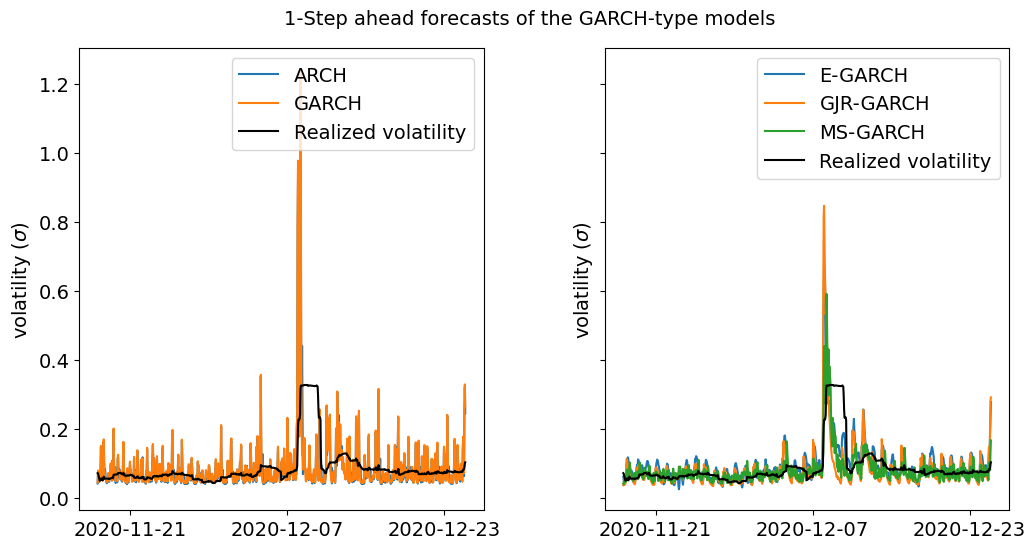

In [301]:
vis = 900
start = 0
fig, axs = plt.subplots(1, 2, figsize=(12, 6),  sharey=True)  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 16

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], preds_arch_std_1[start:(start+vis)].values, label='ARCH')
axs[0].plot(dates[start:(start+vis)], preds_garch_std_1[start:(start+vis)].values, label='GARCH')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_ylabel('volatility ($\sigma$)')

# Plot on the first subplot
axs[1].plot(dates[start:(start+vis)], preds_e_garch_std_1[start:(start+vis)].values, label='E-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_gjr_garch_std_1[start:(start+vis)].values, label='GJR-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_ms_garch_std_1[start:(start+vis)].values, label='MS-GARCH')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_ylabel('volatility ($\sigma$)')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Add a single title in the middle
fig.text(0.5, 0.92, '1-Step ahead forecasts of the GARCH-type models',
         ha='center', fontsize=14)

# Display the figure
axs[0].legend()
axs[1].legend()

# Save the plot as a PNG file
plt.savefig('Figures/Plot_GARCH_1_std.png', dpi=300)  # Specify the filename and DPI (dots per inch)

plt.show()

### 6.1.2 12-Step ahead

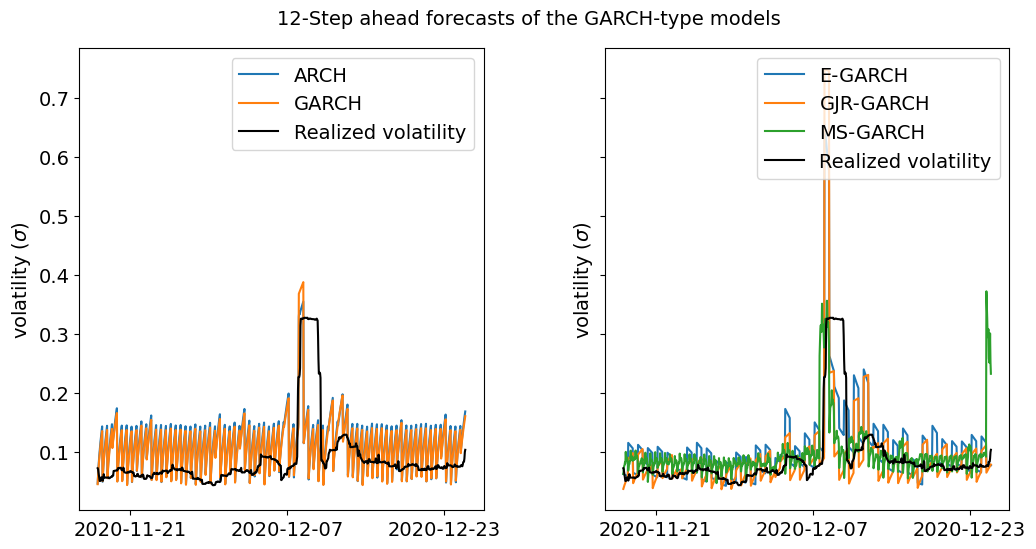

In [302]:
vis = 900
start = 0
fig, axs = plt.subplots(1, 2, figsize=(12, 6),  sharey=True)  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 16

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], preds_arch_std_12[start:(start+vis)].values, label='ARCH')
axs[0].plot(dates[start:(start+vis)], preds_garch_std_12[start:(start+vis)].values, label='GARCH')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_ylabel('volatility ($\sigma$)')

# Plot on the first subplot
axs[1].plot(dates[start:(start+vis)], preds_e_garch_std_12[start:(start+vis)].values, label='E-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_gjr_garch_std_12[start:(start+vis)].values, label='GJR-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_ms_garch_std_12[start:(start+vis)].values, label='MS-GARCH')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_ylabel('volatility ($\sigma$)')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Add a single title in the middle
fig.text(0.5, 0.92, '12-Step ahead forecasts of the GARCH-type models',
         ha='center', fontsize=14)

# Display the figure
axs[0].legend()
axs[1].legend()

# Save the plot as a PNG file
plt.savefig('Figures/Plot_GARCH_12_std.png', dpi=300)  # Specify the filename and DPI (dots per inch)

plt.show()

### 6.1.3 24-Step ahead

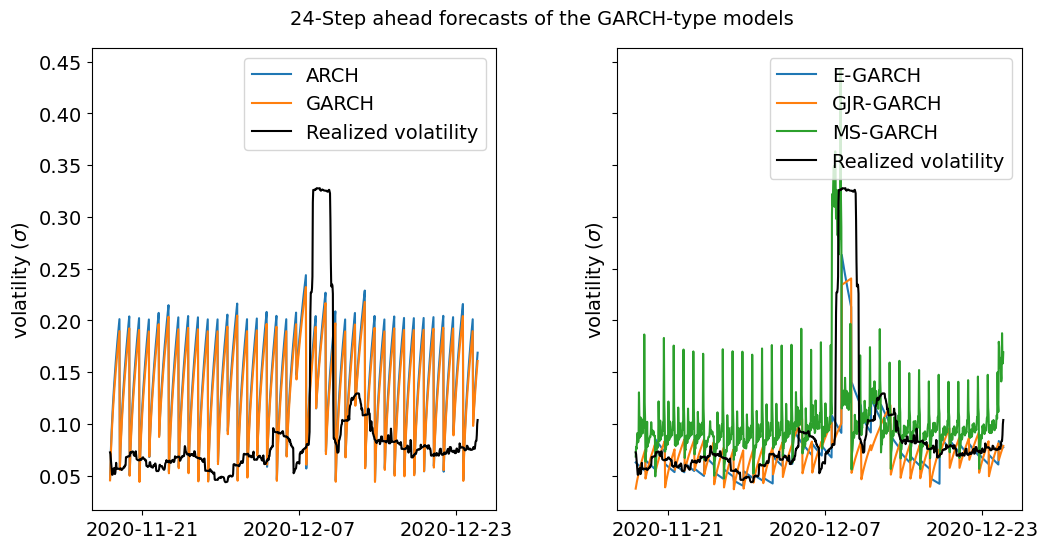

In [303]:
vis = 900
start = 0
fig, axs = plt.subplots(1, 2, figsize=(12, 6),  sharey=True)  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 16

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], preds_arch_std_24[start:(start+vis)].values, label='ARCH')
axs[0].plot(dates[start:(start+vis)], preds_garch_std_24[start:(start+vis)].values, label='GARCH')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_ylabel('volatility ($\sigma$)')

# Plot on the first subplot
axs[1].plot(dates[start:(start+vis)], preds_e_garch_std_24[start:(start+vis)].values, label='E-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_gjr_garch_std_24[start:(start+vis)].values, label='GJR-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_ms_garch_std_24[start:(start+vis)].values, label='MS-GARCH')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_ylabel('volatility ($\sigma$)')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Add a single title in the middle
fig.text(0.5, 0.92, '24-Step ahead forecasts of the GARCH-type models',
         ha='center', fontsize=14)

# Display the figure
axs[0].legend()
axs[1].legend()

# Save the plot as a PNG file
plt.savefig('Figures/Plot_GARCH_24_std.png', dpi=300)  # Specify the filename and DPI (dots per inch)

plt.show()

## 6.2.4 LSTM vs GARCH

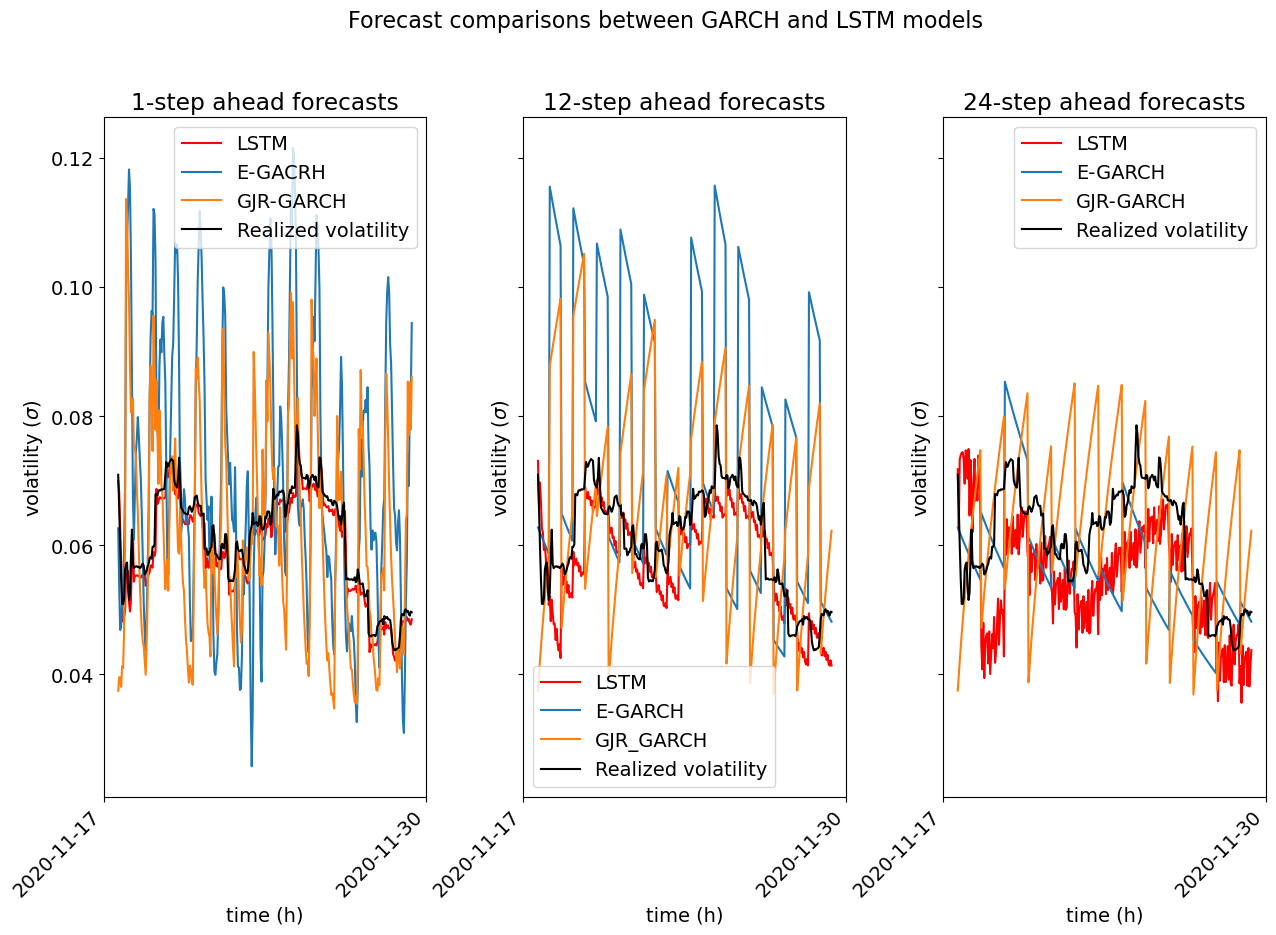

In [632]:
vis = 300
start = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 10),  sharey=True)  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 200

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], lstm_preds_1[start:(start+vis)], color='red',  label='LSTM')
axs[0].plot(dates[start:(start+vis)], preds_e_garch_std_1[start:(start+vis)].values, label='E-GACRH')
axs[0].plot(dates[start:(start+vis)], preds_gjr_garch_std_1[start:(start+vis)].values, label='GJR-GARCH')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_xlabel('time (h)')
axs[0].set_ylabel('volatility ($\sigma$)')
axs[0].set_title('1-step ahead forecasts')

# Plot on the second subplot (identical to the first subplot)
axs[1].plot(dates[start:(start+vis)], lstm_preds_12[start:(start+vis)], color='red', label='LSTM')
axs[1].plot(dates[start:(start+vis)], preds_e_garch_std_12[start:(start+vis)].values, label='E-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_gjr_garch_std_12[start:(start+vis)].values, label='GJR_GARCH')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_xlabel('time (h)')
axs[1].set_ylabel('volatility ($\sigma$)')
axs[1].set_title('12-step ahead forecasts')

# Plot on the second subplot (identical to the first subplot)
axs[2].plot(dates[start:(start+vis)], lstm_preds_24[start:(start+vis)], color='red', label='LSTM')
axs[2].plot(dates[start:(start+vis)], preds_e_garch_std_24[start:(start+vis)].values, label='E-GARCH')
axs[2].plot(dates[start:(start+vis)], preds_gjr_garch_std_24[start:(start+vis)].values, label='GJR-GARCH')
axs[2].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[2].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[2].set_xlabel('time (h)')
axs[2].set_ylabel('volatility ($\sigma$)')
axs[2].set_title('24-step ahead forecasts')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Add a single title in the middle
fig.text(0.5, 0.97, 'Forecast comparisons between GARCH and LSTM models',
         ha='center', fontsize=16)

fig.autofmt_xdate(rotation=45)

# Display the figure
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Export to png
plt.savefig('5. Figures/Plot_LSTM_vs_GARCH_multistep.png', dpi=300)  # Specify the filename and DPI (dots per inch)


plt.show()

## 6.2.3 LSTM vs Hybrid models

## Multi-step ahead

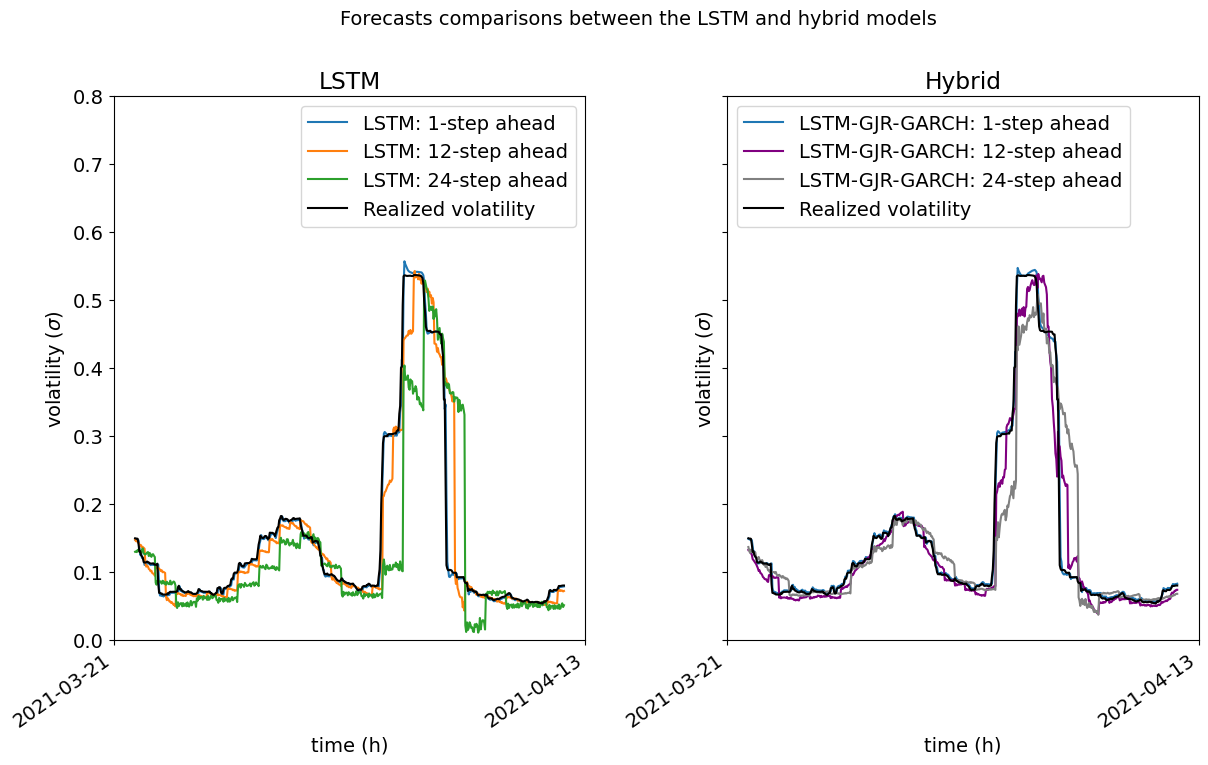

In [645]:
vis = 500
start = 3000
fig, axs = plt.subplots(1, 2, figsize=(14, 8),  sharey=True)  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 100

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], lstm_preds_1[start:(start+vis)], label='LSTM: 1-step ahead')
axs[0].plot(dates[start:(start+vis)], lstm_preds_12[start:(start+vis)], label='LSTM: 12-step ahead')
axs[0].plot(dates[start:(start+vis)], lstm_preds_24[start:(start+vis)], label='LSTM: 24-step ahead')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_xlabel('time (h)')
axs[0].set_ylabel('volatility ($\sigma$)')
axs[0].set_title('LSTM')

# Plot on the second subplot (identical to the first subplot)
axs[1].plot(dates[start:(start+vis)], lstm_preds_gjrgarch_norm_1[start:(start+vis)], label='LSTM-GJR-GARCH: 1-step ahead')
axs[1].plot(dates[start:(start+vis)], lstm_preds_gjrgarch_norm_12[start:(start+vis)],color='#800080', label='LSTM-GJR-GARCH: 12-step ahead')
axs[1].plot(dates[start:(start+vis)], lstm_preds_gjrgarch_norm_24[start:(start+vis)], color='#808080', label='LSTM-GJR-GARCH: 24-step ahead')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_xlabel('time (h)')
axs[1].set_ylabel('volatility ($\sigma$)')
axs[1].set_title('Hybrid')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Add a single title in the middle
fig.text(0.5, 0.97, 'Forecasts comparisons between the LSTM and hybrid models',
         ha='center', fontsize=14)

# Tilt x-axis labels
fig.autofmt_xdate(rotation=35)

# Display the figure
axs[0].legend()
axs[1].legend()
axs[1].legend(loc='upper left')

axs[0].set_ylim([0, 0.8])
axs[1].set_ylim([0, 0.8])


# Export to png
plt.savefig('5. Figures/Plot_LSTM_vs_Hybrid.png', dpi=300)  # Specify the filename

plt.show()

# 7. Residual analysis

## 7.1 1-step ahead residuals

In [113]:
realized_volatility = rv[(len(rv)-20000):]

In [ ]:
resid_lstm_preds_gjrgarch_ged_1 = lstm_preds_gjrgarch_ged_1[0:5000].squeeze() - rv[(len(rv)-obs_test):((len(rv)-obs_test)+5000)]

In [120]:
resid_lstm_preds_1 = lstm_preds_1.squeeze() - realized_volatility
resid_preds_egarch_std_1 = preds_e_garch_std_1.squeeze() - realized_volatility
resid_lstm_preds_gjrgarch_ged_1 = lstm_preds_gjrgarch_ged_1[5000:25000].squeeze() - realized_volatility

## Grid with plot, ACF and histogram

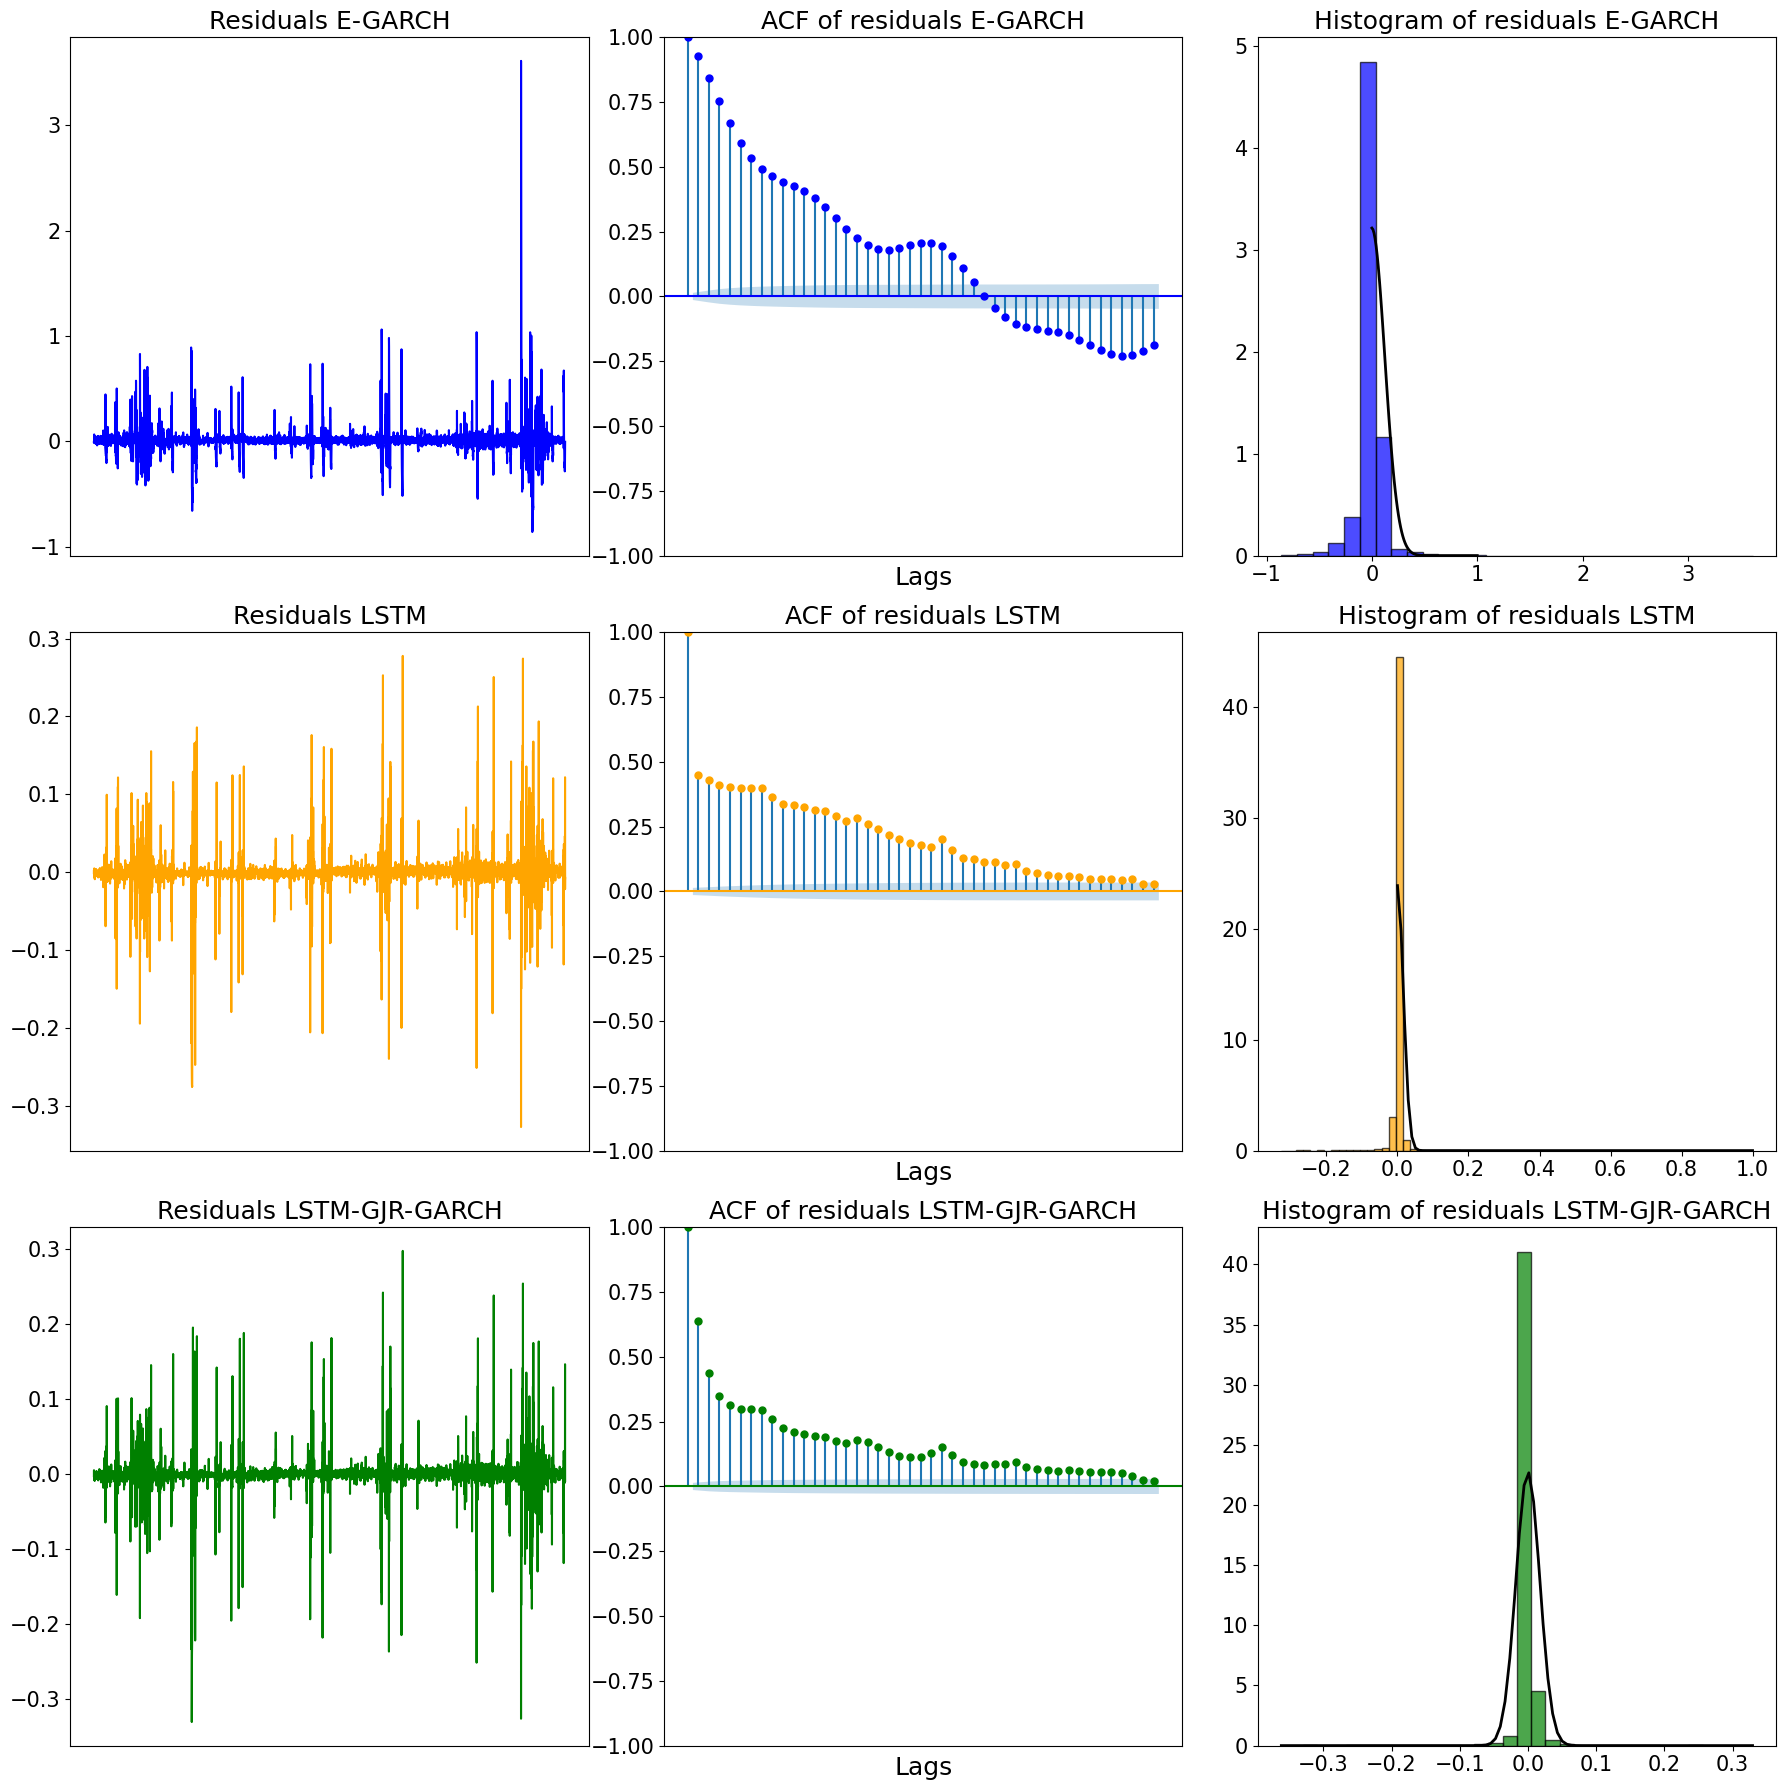

In [134]:
# Create 3 time series
time_series_1 = resid_preds_egarch_std_1
time_series_2 = resid_lstm_preds_1
time_series_3 = resid_lstm_preds_gjrgarch_ged_1

fig, axs = plt.subplots(3, 3, figsize=(18, 18))

title_size = 18 # choose your desired title size
tick_size = 15 # choose your desired tick size

# First row
axs[0, 0].plot(time_series_1, color='blue')
axs[0, 0].set_title('Residuals E-GARCH',  fontsize=title_size)
sm.graphics.tsa.plot_acf(time_series_1, ax=axs[0, 1], color='blue')
axs[0, 1].set_title('ACF of residuals E-GARCH',  fontsize=title_size)
axs[0, 2].hist(time_series_1, bins=30, edgecolor='black', alpha=0.7, density=True, color='blue')
mu, std = norm.fit(time_series_1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[0, 2].plot(x, p, 'k', linewidth=2)
axs[0, 2].set_title('Histogram of residuals E-GARCH',  fontsize=title_size)
axs[0, 0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[0, 1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[0, 2].tick_params(axis='both', which='major', labelsize=tick_size)

# Second row
axs[1, 0].plot(time_series_2, color='orange')
axs[1, 0].set_title('Residuals LSTM',  fontsize=title_size)
sm.graphics.tsa.plot_acf(time_series_2, ax=axs[1, 1], color='orange')
axs[1, 1].set_title('ACF of residuals LSTM',  fontsize=title_size)
axs[1, 2].hist(time_series_2, bins=30, edgecolor='black', alpha=0.7, density=True, color='orange')
mu, std = norm.fit(time_series_2)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[1, 2].plot(x, p, 'k', linewidth=2)
axs[1, 2].set_title('Histogram of residuals LSTM',  fontsize=title_size)
axs[1, 0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1, 1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1, 2].tick_params(axis='both', which='major', labelsize=tick_size)

# Third row
axs[2, 0].plot(time_series_3, color='green')
axs[2, 0].set_title('Residuals LSTM-GJR-GARCH',  fontsize=title_size)
sm.graphics.tsa.plot_acf(time_series_3, ax=axs[2, 1], color='green')
axs[2, 1].set_title('ACF of residuals LSTM-GJR-GARCH',  fontsize=title_size)
axs[2, 2].hist(time_series_3, bins=30, edgecolor='black', alpha=0.7, density=True, color='green')
mu, std = norm.fit(time_series_3)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[2, 2].plot(x, p, 'k', linewidth=2)
axs[2, 2].set_title('Histogram of residuals LSTM-GJR-GARCH',  fontsize=title_size)
axs[2, 0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2, 1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2, 2].tick_params(axis='both', which='major', labelsize=tick_size)

# Set max ticks
n_ticks_x = 5
axs[0, 0].xaxis.set_major_locator(MaxNLocator(nbins=n_ticks_x))
axs[1, 0].xaxis.set_major_locator(MaxNLocator(nbins=n_ticks_x))
axs[2, 0].xaxis.set_major_locator(MaxNLocator(nbins=n_ticks_x))

# Remove x ticks
axs[0, 0].set_xticks([])
axs[1, 0].set_xticks([])
axs[2, 0].set_xticks([])

axs[0, 1].set_xticks([])
axs[1, 1].set_xticks([])
axs[2, 1].set_xticks([])

axs[0, 1].set_xlabel('Lags', fontsize = 18)
axs[1, 1].set_xlabel('Lags', fontsize = 18)
axs[2, 1].set_xlabel('Lags', fontsize = 18)

fig.subplots_adjust(hspace=1, wspace=1) # wspace for width space
plt.tight_layout()
plt.show()

# 8. ARMA modeling residuals

### Train & connect in-sample residuals for training ARMA models with out-of-sample residuals for error predictions

In [149]:
# For in-sample residual calculations
obs_test = 25000
lstm_preds_1_resid = univariate_lstm_preds_shift(scaled_rv, obs_test, start, d, h, epochs, units, nodes, verbose, LR, activation_lstm, rv, shift)
lstm_preds_gjrgarch_ged_1_resid = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

391/391 [==============================] - 17s 42ms/step


In [150]:
print(len(lstm_preds_1_resid))
print(len(lstm_preds_gjrgarch_ged_1_resid))

25000
25000


In [173]:
# Calculate in-sample residuals
resid_lstm_preds_1_train = lstm_preds_1_resid[0:5000].squeeze() - rv[(len(rv)-25000):(len(rv)-20000)]
resid_lstm_preds_gjrgarch_ged_1_train = lstm_preds_gjrgarch_ged_1_resid[0:5000].squeeze() - rv[(len(rv)-25000):(len(rv)-20000)]

In [174]:
# Calculate out-of-sample residuals
resid_lstm_preds_1 = lstm_preds_1.squeeze() - rv[(len(rv)-20000):]
resid_lstm_preds_gjrgarch_ged_1 = lstm_preds_gjrgarch_ged_1.squeeze() - rv[(len(rv)-20000):]

In [175]:
# Connect residual vectors
resid_vec_lstm_preds_1 = np.concatenate((resid_lstm_preds_1_train, resid_lstm_preds_1))
resid_vec_lstm_preds_gjrgarch_ged_1 = np.concatenate((resid_lstm_preds_gjrgarch_ged_1_train, resid_lstm_preds_gjrgarch_ged_1))

## 8.1 E-GARCH predictions

In [648]:
# Realized volatility
obs_test = 20000
realized_volatility = rv[(len(rv)-obs_test):]

# Take LSTM 1-step ahead as initial model
resid_preds_egarch_std__1 = preds_e_garch_std_1.squeeze() - realized_volatility

# Split data into test and training
nobs = len(resid_preds_egarch_std__1)
n_train = 5000
series_train = resid_preds_egarch_std__1.iloc[:n_train]

# Fit the model using the training dataset
model = sm.tsa.ARIMA(series_train, order=(5,0,5))
fit = model.fit()

# Compute the first forecast based only on the training dataset
forecasts = []
res = fit
forecasts.append(res.forecast())

# Now step through the test observations:
# (a) add the new observation without refitting the model
# (b) produce a new forecast
for t in tqdm(range(n_train, nobs)):
    # Update the results by appending the next observation
    res = res.append(resid_preds_egarch_std__1.iloc[t:t + 1], refit=False)
    
    # Produce a forecast for t+1 based on data through t
    forecasts.append(res.forecast())

forecasts = np.array(forecasts[0:(obs_test-n_train)]).squeeze()

/Users/thomasvollebregt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/thomasvollebregt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/thomasvollebregt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/15000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
y_new_egarch = preds_e_garch_std_1[n_train:obs_test].squeeze() - forecasts

print(mse(preds_e_garch_std_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mse(y_new_egarch, realized_volatility[n_train:obs_test]))

In [ ]:
print(mae(preds_e_garch_std_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mae(y_new_egarch, realized_volatility[n_train:obs_test]))

## 8.2 LSTM predictions

In [ ]:
# Connect in-sample and out-of-sample residuals (!)

In [ ]:
# Realized volatility
obs_test = 25000
realized_volatility = rv[(len(rv)-obs_test):]

# Take LSTM 1-step ahead as initial model
resid_vec_lstm_preds_1 = resid_vec_lstm_preds_1.squeeze() - realized_volatility

# Split data into test and training
nobs = len(resid_vec_lstm_preds_1)
n_train = 5000
series_train = resid_vec_lstm_preds_1[:n_train]

# Fit the model using the training dataset
model = sm.tsa.ARIMA(series_train, order=(5,0,5))
fit = model.fit()

# Compute the first forecast based only on the training dataset
forecasts = []
res = fit
forecasts.append(res.forecast())

# Now step through the test observations:
# (a) add the new observation without refitting the model
# (b) produce a new forecast
for t in tqdm(range(n_train, nobs)):
    # Update the results by appending the next observation
    res = res.append(resid_vec_lstm_preds_1[t:t + 1], refit=False)
    
    # Produce a forecast for t+1 based on data through t
    forecasts.append(res.forecast())

forecasts = np.array(forecasts[0:(obs_test-n_train)]).squeeze()

y_new_hybrid = resid_vec_lstm_preds_1[n_train:obs_test].squeeze() - forecasts

/Users/thomasvollebregt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
print(mse(resid_vec_lstm_preds_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mse(y_new_hybrid, realized_volatility[n_train:obs_test]))

print(mae(resid_vec_lstm_preds_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mae(y_new_hybrid, realized_volatility[n_train:obs_test]))

## 8.3 LSTM-GJR-GARCH (GED) predictions 

In [ ]:
# Realized volatility
obs_test = 25000
realized_volatility = rv[(len(rv)-obs_test):]

# Take LSTM 1-step ahead as initial model
resid_vec_lstm_preds_gjrgarch_ged_1 = resid_vec_lstm_preds_gjrgarch_ged_1.squeeze() - realized_volatility

# Split data into test and training
nobs = len(resid_vec_lstm_preds_gjrgarch_ged_1)
n_train = 5000
series_train = resid_vec_lstm_preds_gjrgarch_ged_1.iloc[:n_train]

# Fit the model using the training dataset
model = sm.tsa.ARIMA(series_train, order=(5,0,5))
fit = model.fit()

# Compute the first forecast based only on the training dataset
forecasts = []
res = fit
forecasts.append(res.forecast())

# Now step through the test observations:
# (a) add the new observation without refitting the model
# (b) produce a new forecast
for t in tqdm(range(n_train, nobs)):
    # Update the results by appending the next observation
    res = res.append(resid_vec_lstm_preds_gjrgarch_ged_1.iloc[t:t + 1], refit=False)
    
    # Produce a forecast for t+1 based on data through t
    forecasts.append(res.forecast())

forecasts = np.array(forecasts[0:(obs_test-n_train)]).squeeze()

y_new_hybrid = resid_vec_lstm_preds_gjrgarch_ged_1[n_train:obs_test].squeeze() - forecasts

In [ ]:
print(mse(resid_vec_lstm_preds_gjrgarch_ged_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mse(y_new_hybrid, realized_volatility[n_train:obs_test]))

print(mae(resid_vec_lstm_preds_gjrgarch_ged_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mae(y_new_hybrid, realized_volatility[n_train:obs_test]))

In [654]:
print(mse(rv[(len(rv)-obs_test-1):(len(rv)-1)], rv[(len(rv)-obs_test):]))
print(mae(rv[(len(rv)-obs_test-1):(len(rv)-1)], rv[(len(rv)-obs_test):]))

0.0001768543161751787
0.003037674149914218


## 8.4 Create grid with diagnostic plots

In [655]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm

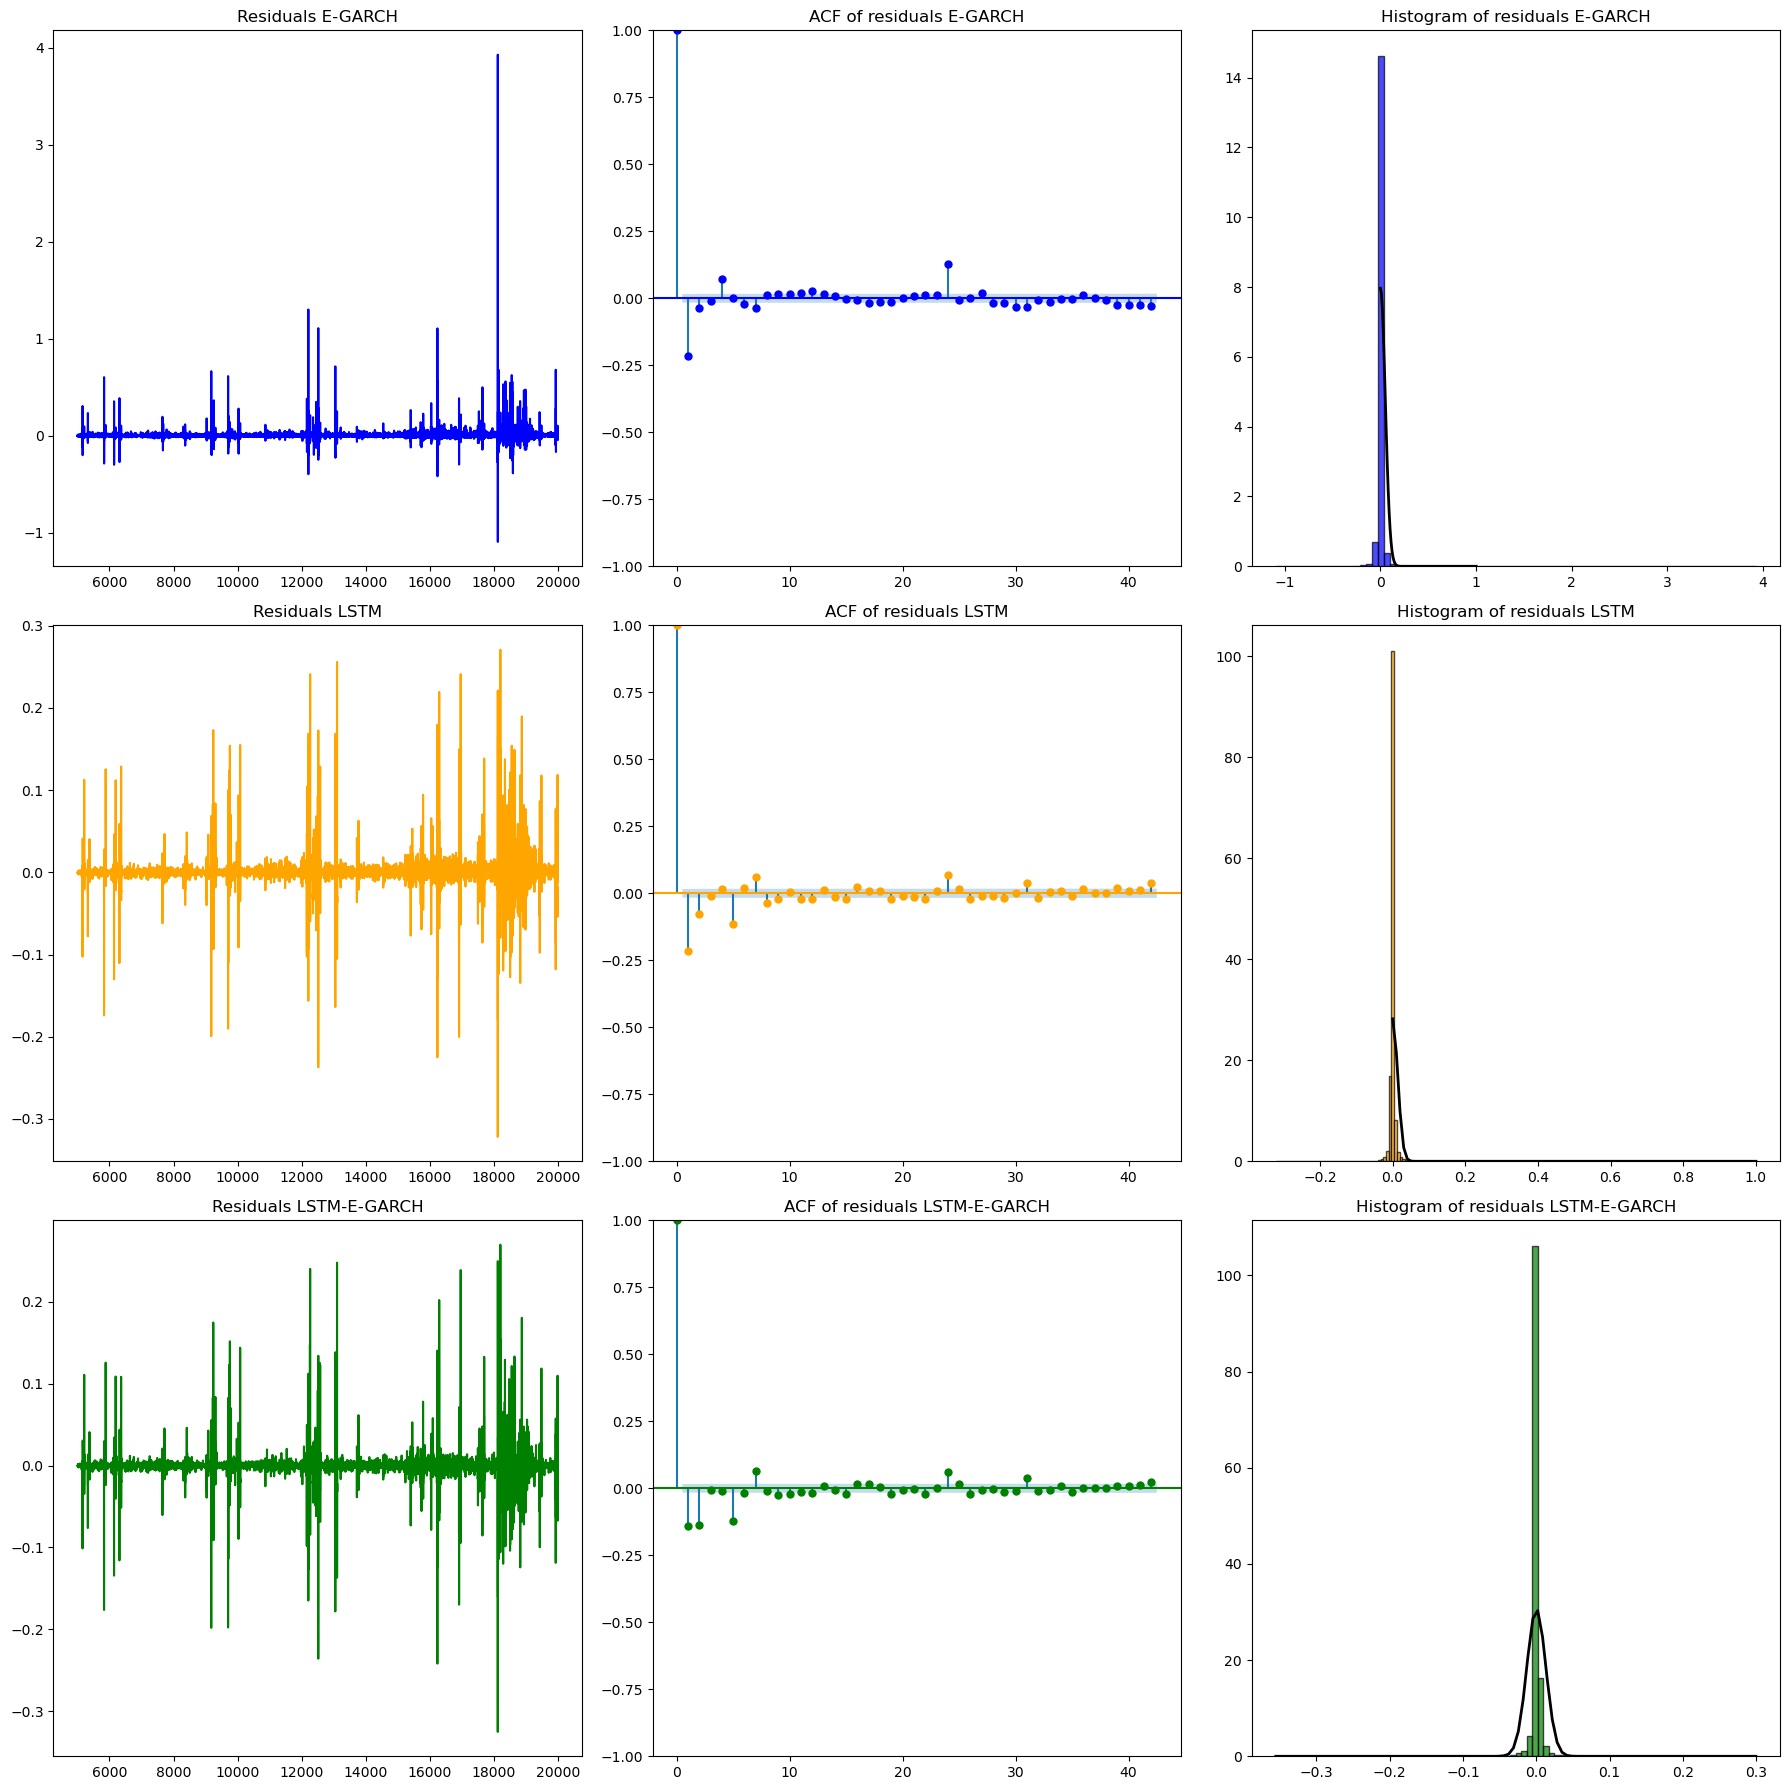

In [129]:
# Create 3 time series
time_series_1 = y_new_egarch - realized_volatility[n_train:obs_test]
time_series_2 = y_new_lstm - realized_volatility[n_train:obs_test]
time_series_3 = y_new_hybrid - realized_volatility[n_train:obs_test]

fig, axs = plt.subplots(3, 3, figsize=(18, 18))

bins = 80
# First row
axs[0, 0].plot(time_series_1, color='blue')
axs[0, 0].set_title('Residuals E-GARCH')
sm.graphics.tsa.plot_acf(time_series_1, ax=axs[0, 1], color='blue')
axs[0, 1].set_title('ACF of residuals E-GARCH')
axs[0, 2].hist(time_series_1, bins=bins, edgecolor='black', alpha=0.7, density=True, color='blue')
mu, std = norm.fit(time_series_1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[0, 2].plot(x, p, 'k', linewidth=2)
axs[0, 2].set_title('Histogram of residuals E-GARCH')

# Second row
axs[1, 0].plot(time_series_2, color='orange')
axs[1, 0].set_title('Residuals LSTM')
sm.graphics.tsa.plot_acf(time_series_2, ax=axs[1, 1], color='orange')
axs[1, 1].set_title('ACF of residuals LSTM')
axs[1, 2].hist(time_series_2, bins=bins, edgecolor='black', alpha=0.7, density=True, color='orange')
mu, std = norm.fit(time_series_2)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[1, 2].plot(x, p, 'k', linewidth=2)
axs[1, 2].set_title('Histogram of residuals LSTM')

# Third row
axs[2, 0].plot(time_series_3, color='green')
axs[2, 0].set_title('Residuals LSTM-E-GARCH')
sm.graphics.tsa.plot_acf(time_series_3, ax=axs[2, 1], color='green')
axs[2, 1].set_title('ACF of residuals LSTM-E-GARCH')
axs[2, 2].hist(time_series_3, bins=bins, edgecolor='black', alpha=0.7, density=True, color='green')
mu, std = norm.fit(time_series_3)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[2, 2].plot(x, p, 'k', linewidth=2)
axs[2, 2].set_title('Histogram of residuals LSTM-E-GARCH')

fig.subplots_adjust(hspace=0.9)
plt.tight_layout()
plt.show()

# 9. Plotting the loss curves

In [666]:
def lstm_model_loss(X_train, y_train, X_val, y_val, verbose, epochs, d, units, nodes, LR, activation_lstm):
    # Define parameters
    verbose, epochs, batch_size = verbose, epochs, d
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    # Define model
    model = Sequential()
    model.add(LSTM(units, activation=activation_lstm, input_shape=(n_timesteps, n_features))) # LSTM units
    model.add(Dense(nodes, activation='relu')) # nodes
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer=Adam(learning_rate = LR))

    # fit network
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val))

    return model, history

In [667]:
def lstm_model_loss_bivariate(rv_data, filt_data, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h):
   
    scaled_filt = filt_data
    h = h

    X_3D_1 , y_3D_1 = make_supervised(rv_data, obs_test, d, h, 0)    
    X_3D_filt_1, y_3D_filt_1 = make_supervised(scaled_filt, obs_test, d, h, start = 0) #y_3D_filt_1 is not used because the filtered volatility ouputs are not used in training
    
    #Training set 1
    features = 2
    X_3D_2f_1 = np.zeros((X_3D_filt_1.shape[0], X_3D_filt_1.shape[1], features))
    X_3D_1 = np.squeeze(X_3D_1)
    X_3D_filt_1 = np.squeeze(X_3D_filt_1)
    X_3D_2f_1[:,:,0] = X_3D_1
    X_3D_2f_1[:,:,1] = X_3D_filt_1
    
    verbose = 0
    
    #Create validation sets
    X_3D_val, y_3D_val = make_supervised(rv_data, 0, d, h, 0)
    X_3D_val_filt_1, y_3D_val_filt_1 = make_supervised(scaled_filt, 0, d, h, 0)
    
    X_val_2f = X_3D_val[-300:, :, :]
    X__val_filt_2f = X_3D_val_filt_1[-300:, :, :]
    y_val_3D = y_3D_val[-300:, :, :]
    
    #Training set 1
    features = 2
    X_val_2f_3D = np.zeros((X_val_2f.shape[0], X_val_2f.shape[1], features))
    X_val_2f = np.squeeze(X_val_2f)
    X__val_filt_2f = np.squeeze(X__val_filt_2f)
    X_val_2f_3D[:,:,0] = X_val_2f
    X_val_2f_3D[:,:,1] = X__val_filt_2f

    model, history = lstm_model_loss(X_3D_2f_1, y_3D_1, X_val_2f_3D, y_val_3D, verbose, epochs, d, units, nodes, LR, activation_lstm)
    
    return model, history

### LSTM multi-step ahead loss functions

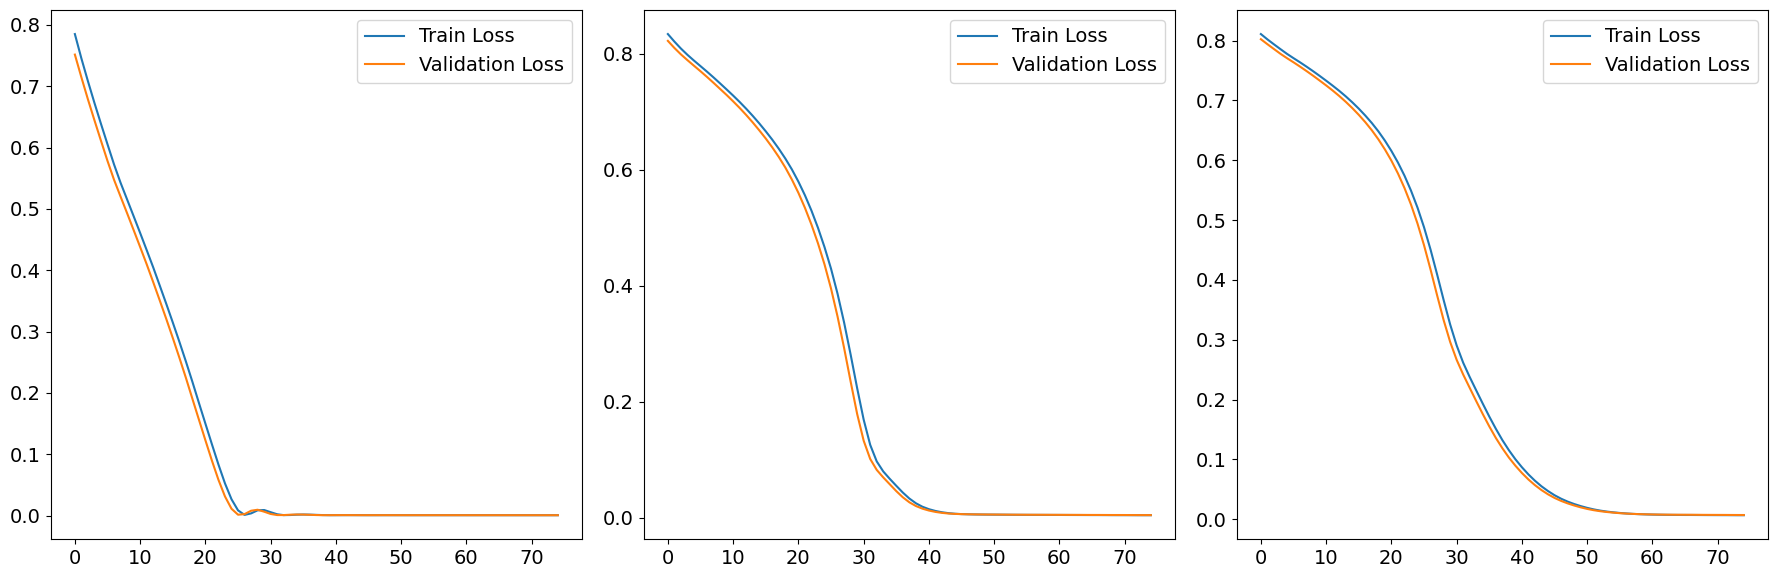

In [682]:
obs_test = 0 
start = 0
h_values = [1, 12, 24]
LR = 0.0001
epochs = 75
obs_test = 20000

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # create 3 subplots next to each other

for i, h in enumerate(h_values):
    X_3D_val, y_3D_val = make_supervised(scaled_rv, obs_test, d, h, start)
    X_val = X_3D_val[-300:, :, :]
    y_val = y_3D_val[-300:, :, :]
    X_3D, y_3D = make_supervised(scaled_rv, obs_test, d, h, start)
    model, history = lstm_model_loss(X_3D, y_3D, X_val, y_val, verbose, epochs, d, units, nodes, LR, activation_lstm)

    # Plot learning curves on the i-th subplot
    axs[i].plot(history.history['loss'], label='Train Loss')
    axs[i].plot(history.history['val_loss'], label='Validation Loss')
    #axs[i].set_title(f'Loss function for h={h}')
    #axs[i].set_xlabel('Epochs')  # Add label for x-axis
    
    # Increase the size of x and y tick labels
    axes[i].tick_params(axis='x', labelsize=20, rotation=45)  # Increase x-axis label size and rotate labels
    axes[i].tick_params(axis='y', labelsize=2)  # Increase y-axis label size

    # Increase the size of x-label
    axes[i].set_xlabel('Epochs', fontsize=22)  

    # Increase the size of legend
    axes[i].legend(fontsize=17)
    axs[i].legend()

plt.tight_layout()  # adjust subplot parameters to give specified padding
plt.show()

### Hybrid LSTM loss functions

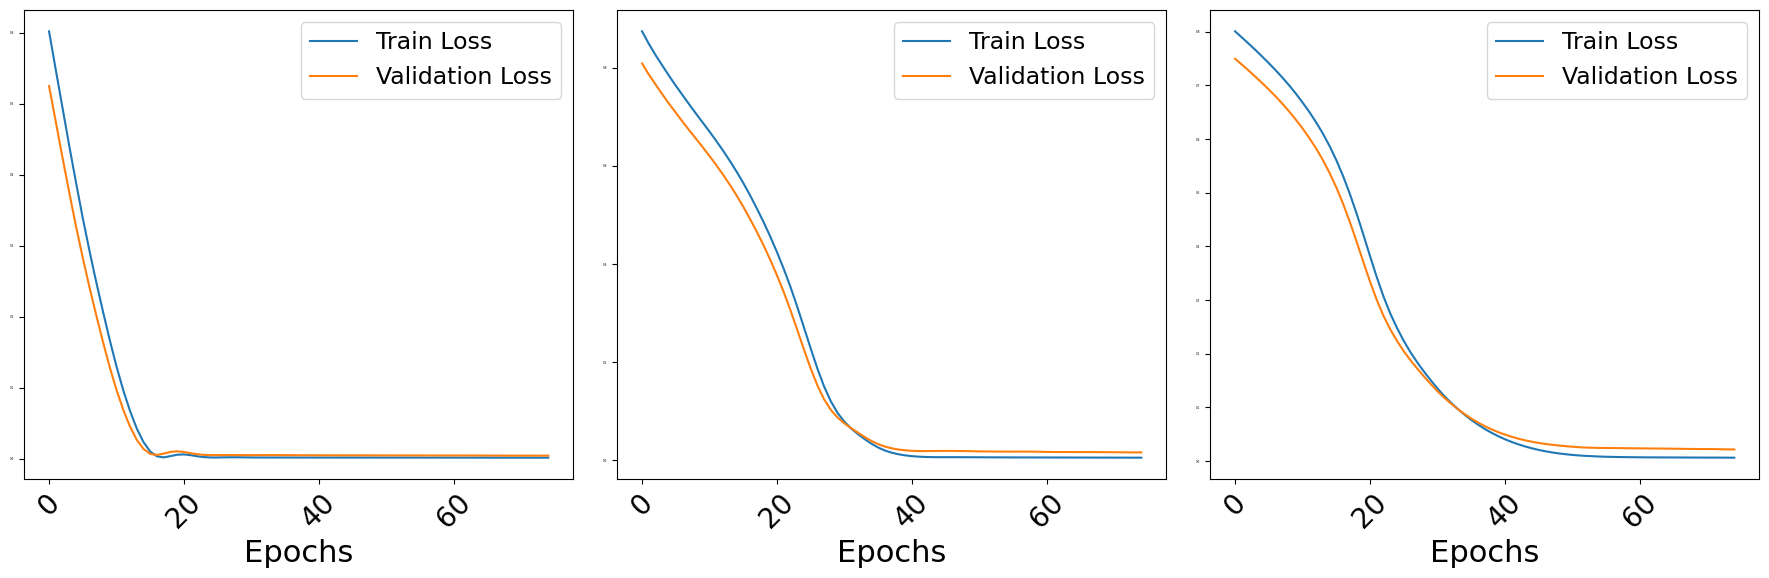

In [680]:
# NEWEST VERSION
LR = 0.0001
epochs = 75
h_values = [1, 12, 24]
rv_data = scaled_rv
filt_data = scaled_data(np.array(feat_e_garch_std_1)).flatten()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # Create a figure with three subplots

for i, h in enumerate(h_values):
    obs_test = 20000  # Assuming a certain value for obs_test
    X_3D, y_3D = make_supervised(scaled_rv, obs_test, d, h, start)
    model, history = lstm_model_loss_bivariate(rv_data, filt_data, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h)

    # Plot learning curves on the i-th subplot
    axes[i].plot(history.history['loss'], label='Train Loss')
    axes[i].plot(history.history['val_loss'], label='Validation Loss')

    # Increase the size of x and y tick labels
    axes[i].tick_params(axis='x', labelsize=20, rotation=45)  # Increase x-axis label size and rotate labels
    axes[i].tick_params(axis='y', labelsize=2)  # Increase y-axis label size

    # Increase the size of x-label
    axes[i].set_xlabel('Epochs', fontsize=22)  

    # Increase the size of legend
    axes[i].legend(fontsize=17)

plt.tight_layout()
plt.show()


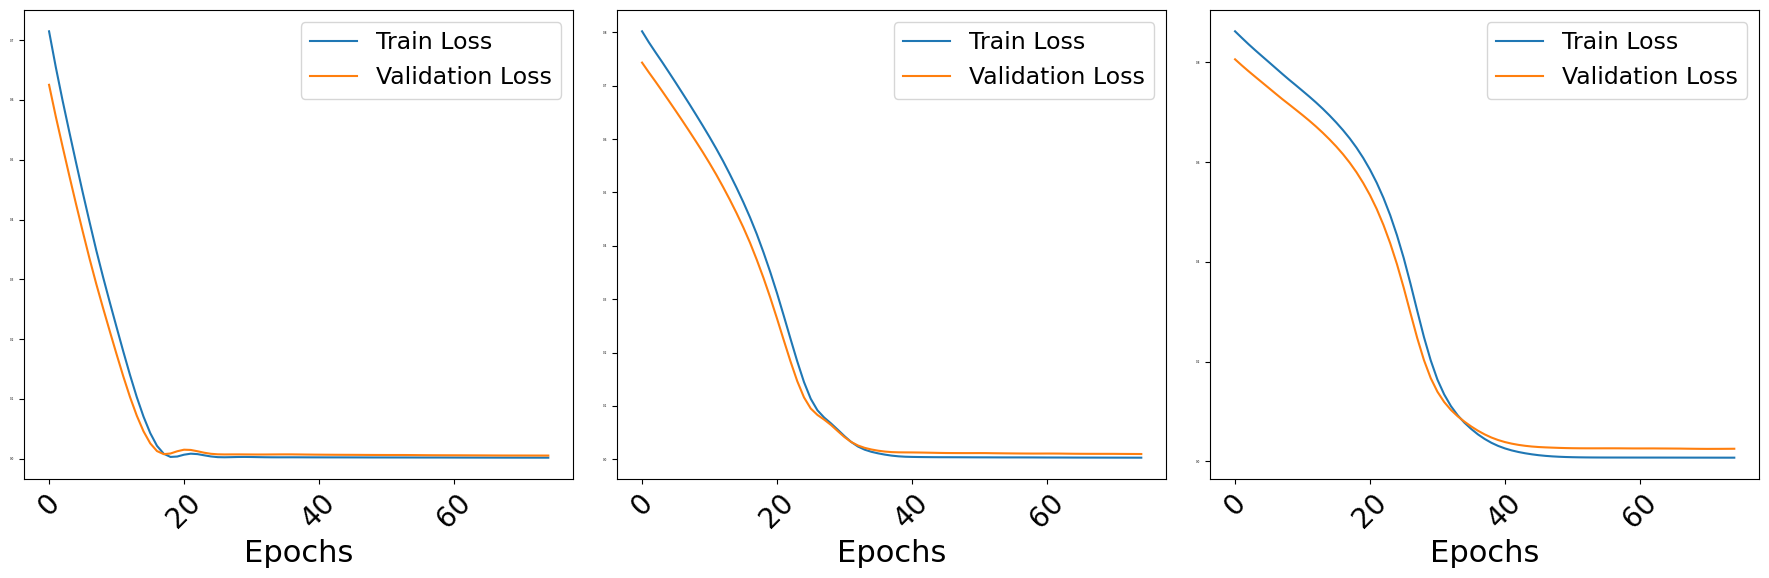

In [681]:
# NEWEST VERSION
LR = 0.0001
epochs = 75
h_values = [1, 12, 24]
rv_data = scaled_rv
filt_data = scaled_data(np.array(feat_gjr_garch_std_1)).flatten()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # Create a figure with three subplots

for i, h in enumerate(h_values):
    obs_test = 20000  # Assuming a certain value for obs_test
    X_3D, y_3D = make_supervised(scaled_rv, obs_test, d, h, start)
    model, history = lstm_model_loss_bivariate(rv_data, filt_data, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h)

    # Plot learning curves on the i-th subplot
    axes[i].plot(history.history['loss'], label='Train Loss')
    axes[i].plot(history.history['val_loss'], label='Validation Loss')

    # Removing the title
    # axes[i].set_title(f'Loss function for h={h}')  # Comment this line

    # Increase the size of x and y tick labels
    axes[i].tick_params(axis='x', labelsize=20, rotation=45)  # Increase x-axis label size and rotate labels
    axes[i].tick_params(axis='y', labelsize=2)  # Increase y-axis label size

    # Increase the size of x-label
    axes[i].set_xlabel('Epochs', fontsize=22)  

    # Increase the size of legend
    axes[i].legend(fontsize=17)

plt.tight_layout()
plt.show()


## 9. Visualizing activation functions

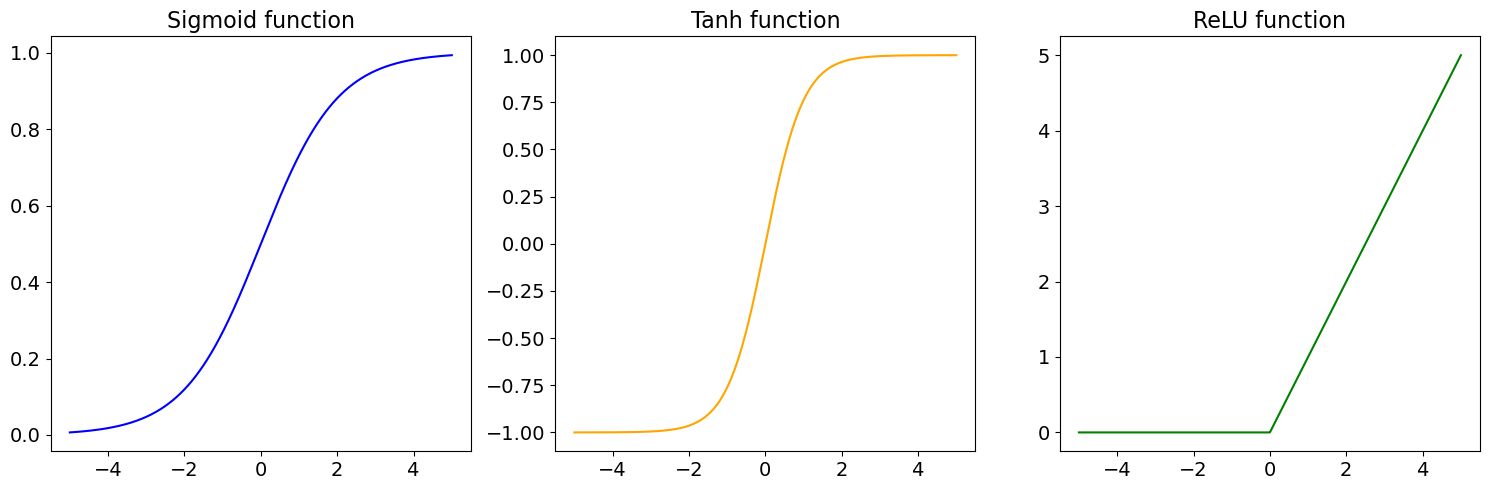

In [237]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

# Generate a range of values
x = np.linspace(-5, 5, 1000)

# Calculate the function values
y_sigmoid = sigmoid(x)
y_tanh = tanh(x)
y_relu = relu(x)

# Create the plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x, y_sigmoid, color='blue')
plt.title('Sigmoid function', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(1, 3, 2)
plt.plot(x, y_tanh, color='orange')
plt.title('Tanh function', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(1, 3, 3)
plt.plot(x, y_relu, color='green')
plt.title('ReLU function', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

# Show the plots
plt.tight_layout()
plt.show()

## 10. Quantifying performance gains in plots

In [251]:
# Define MSE gains, calculated by hand
mse_gains_norm_1 = [-29.0, -14.2, -36.6, -26.7, 0.0]
mse_gains_norm_12 = [-17.9, -24.3, -22.8, -33.6, -4.6]
mse_gains_norm_24 = [-8.0, -22.0, -18.5, -25.6, -23.3]

mse_gains_std_1 = [-32.4, -18.2, -39.9, -31.3, 0.0]
mse_gains_std_12 = [-21.9, -30.3, -25.3, -29.0, -4.0]
mse_gains_std_24 = [-10.1, -21.3, -20.0, -21.2, -25.2]

mse_gains_ged_1 = [-25.3, -11.9, -32.3, -20.8, 0.0]
mse_gains_ged_12 = [1.9, -23.8, -24.4, -31.5, -1.5]
mse_gains_ged_24 = [-1.0, -21.0, -22.8, -23.8, -12.4]

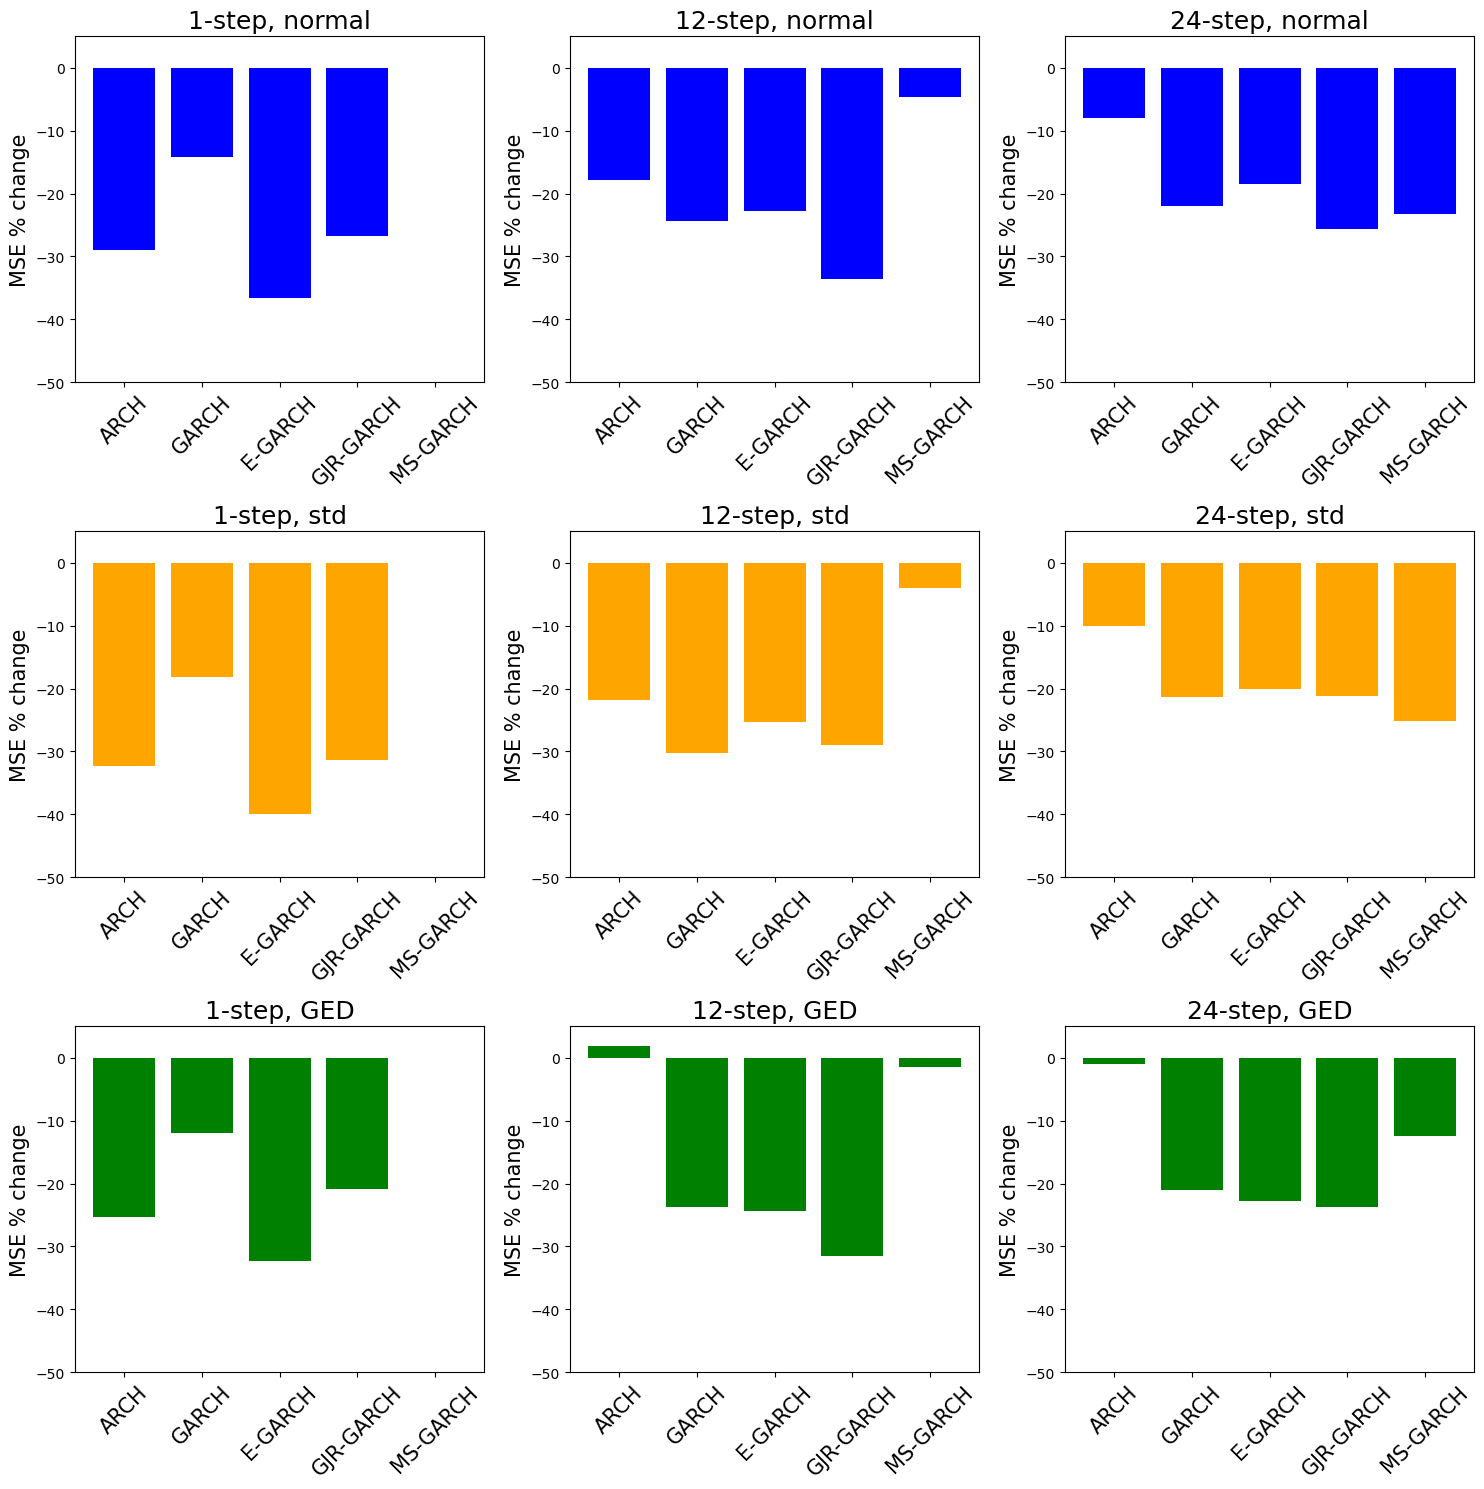

In [259]:
vectors = [mse_gains_norm_1, mse_gains_norm_12, mse_gains_norm_24, 
           mse_gains_std_1, mse_gains_std_12, mse_gains_std_24, 
           mse_gains_ged_1, mse_gains_ged_12, mse_gains_ged_24]

# Create a list of labels for your bars
labels = ['ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH']

# Define titles for each plot
titles = ['1-step, normal', '12-step, normal', '24-step, normal',
          '1-step, std', '12-step, std', '24-step, std',
          '1-step, GED', '12-step, GED', '24-step, GED']

# Define colors for each row
colors = ['blue']*3 + ['orange']*3 + ['green']*3

fig = plt.figure(figsize=(15, 15))  # Adjust the figure size for better display

for i in range(9):
    plt.subplot(3, 3, i+1)  # (nrows, ncols, index)
    plt.bar(labels, vectors[i], color=colors[i])  
    plt.title(titles[i], fontsize=18)  # Adjust title and size
    plt.ylabel('MSE % change', fontsize=15)  # Adjust label and size
    plt.ylim([-50, 5])  # Adjust y-axis range
    plt.xticks(rotation=45, fontsize=15)  # Adjust label rotation and size

# Improve layout
plt.tight_layout()

# Display the plots
plt.show()

## 11. Diebold Mariano tests 

In [ ]:
real_values = rv[(len(rv)-20000):]

In [87]:
garch_forecasts = [preds_arch_norm_12, preds_arch_std_12, preds_arch_ged_12,
                  preds_garch_norm_12, preds_garch_std_12, preds_garch_ged_12,
                  preds_e_garch_norm_12, preds_e_garch_std_12, preds_e_garch_ged_12,
                  preds_gjr_garch_norm_12, preds_gjr_garch_std_12, preds_gjr_garch_ged_12,
                  preds_ms_garch_norm_12, preds_ms_garch_std_12, preds_ms_garch_ged_12]

In [88]:
lstm_preds_12 = lstm_preds_12.iloc[:,0]
lstm_preds_arch_norm_12 = lstm_preds_arch_norm_12.iloc[:,0]
lstm_preds_garch_norm_12 = lstm_preds_garch_norm_12.iloc[:,0]
lstm_preds_egarch_norm_12 = lstm_preds_egarch_norm_12.iloc[:,0]
lstm_preds_gjrgarch_norm_12 = lstm_preds_gjrgarch_norm_12.iloc[:,0]
lstm_preds_msgarch_norm_12 = lstm_preds_msgarch_norm_12.iloc[:,0]
lstm_preds_arch_std_12 = lstm_preds_arch_std_12.iloc[:,0]
lstm_preds_garch_std_12 = lstm_preds_garch_std_12.iloc[:,0]
lstm_preds_egarch_std_12 = lstm_preds_egarch_std_12.iloc[:,0]
lstm_preds_gjrgarch_std_12 = lstm_preds_gjrgarch_std_12.iloc[:,0]
lstm_preds_msgarch_std_12 = lstm_preds_msgarch_std_12.iloc[:,0]
lstm_preds_arch_ged_12 = lstm_preds_arch_ged_12.iloc[:,0]
lstm_preds_garch_ged_12 = lstm_preds_garch_ged_12.iloc[:,0]
lstm_preds_egarch_ged_12 = lstm_preds_egarch_ged_12.iloc[:,0]
lstm_preds_gjrgarch_ged_12 = lstm_preds_gjrgarch_ged_12.iloc[:,0]
lstm_preds_msgarch_ged_12 = lstm_preds_msgarch_ged_12.iloc[:,0]

In [89]:
lstm_forecasts = [lstm_preds_12,
                 lstm_preds_arch_norm_12, lstm_preds_arch_std_12, lstm_preds_arch_ged_12,
                 lstm_preds_garch_norm_12, lstm_preds_garch_std_12, lstm_preds_garch_ged_12,
                 lstm_preds_egarch_norm_12, lstm_preds_egarch_std_12, lstm_preds_egarch_ged_12,
                 lstm_preds_gjrgarch_norm_12, lstm_preds_gjrgarch_std_12, lstm_preds_gjrgarch_ged_12,
                 lstm_preds_msgarch_norm_12, lstm_preds_msgarch_std_12, lstm_preds_msgarch_ged_12]

In [90]:
# Create an empty list
comparison_matrix = []

for i in range(16):
    row = []
    for j in range(16):
        if i == j:
            row.append("-")
        else:
            row.append(np.round(dm_test_2(real_values, lstm_forecasts[i], lstm_forecasts[j], h=1, harvey_adj=True)[1], 3))
    comparison_matrix.append(row)

# Convert list of lists to a numpy array
comparison_matrix = np.array(comparison_matrix)

In [91]:
# Convert numpy array to pandas DataFrame
df = pd.DataFrame(comparison_matrix, columns=['Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3','Column1'])

# Convert DataFrame to LaTeX
latex = df.to_latex(index=False)  # Set index=False if you don't want row indices in your LaTeX table

print(latex)

\begin{tabular}{llllllllllllllll}
\toprule
Column1 & Column2 & Column3 & Column1 & Column2 & Column3 & Column1 & Column2 & Column3 & Column1 & Column2 & Column3 & Column1 & Column2 & Column3 & Column1 \\
\midrule
      - &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &       - &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &   0.066 &   0.003 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &   0.008 &    0.04 \\
    0.0 &     0.0 &       - &     0.0 &     0.0 &     0.0 &     0.0 &    0.03 &   0.949 &   0.076 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &   0.848 \\
    0.0 &     0.0 &     0.0 &       - &     0.0 &     0.0 &   0.465 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &     0.0 &     0.0 &     0.0 &       - &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &   0.855 &   0.829 &   0.967 &    0.26 &   0

/var/folders/f4/r997w8nx5v5022dy1nxllgk00000gn/T/ipykernel_39020/2965912611.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=False)  # Set index=False if you don't want row indices in your LaTeX table


In [84]:
# Create an empty list
comparison_matrix = []

for i in range(15):
    row = []
    for j in range(15):
        if i == j:
            row.append("-")
        else:
            row.append(np.round(dm_test_2(real_values, garch_forecasts[i], garch_forecasts[j], h=1, harvey_adj=True)[1], 3))
    comparison_matrix.append(row)

# Convert list of lists to a numpy array
comparison_matrix = np.array(comparison_matrix)

In [86]:
# Convert numpy array to pandas DataFrame
df = pd.DataFrame(comparison_matrix, columns=['Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3'])

# Convert DataFrame to LaTeX
latex = df.to_latex(index=False)  # Set index=False if you don't want row indices in your LaTeX table

print(latex)

\begin{tabular}{lllllllllllllll}
\toprule
Column1 & Column2 & Column3 & Column1 & Column2 & Column3 & Column1 & Column2 & Column3 & Column1 & Column2 & Column3 & Column1 & Column2 & Column3 \\
\midrule
      - &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &       - &     0.0 &     0.0 &     0.0 &   0.448 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &     0.0 &       - &     0.0 &     0.0 &   0.242 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &     0.0 &     0.0 &       - &     0.0 &     0.0 &   0.068 &   0.183 &   0.818 &    0.02 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &     0.0 &     0.0 &     0.0 &       - &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &   0.448 &   0.242 &     0.0 &    

/var/folders/f4/r997w8nx5v5022dy1nxllgk00000gn/T/ipykernel_39020/2013095257.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=False)  # Set index=False if you don't want row indices in your LaTeX table
